## Replication of the European Commission Debt Sustainability Methodology

This notebook features an updated version of the methodology introduced in "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). For details on the methodology see Annex II, "Methodology and code for implementing the European Commission´s DSA in the context of the economic governance review".

Note that for the analysis to run, data on growth, ageing costs, property income, interest rate and inflation expectations, as well as institutional debt have to be added to "../data/InputData/deterministic_model_data.xlsx". These data have been sourced directly from the European Commission and Bloomberg, and we have no permission to share them publicly.

For comments and suggestions please contact lennard.welslau[at]bruegel[dot]org.

Last update: 26 February 2024

In [2]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from DsaModelClass import DsaModel
from StochasticDsaModelClass import StochasticDsaModel

# Import functions for analysis
from dsa_functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

## Tutorial
This section introduces some of the functionalities of the DsaModel class and the StochasticDsaModel class.

### Initializing the DSA model and projecting the debt ratio

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "DsaModel" can be used, although I recommend always calling the StochasticDsaModel class to have access to all functionalities.

In [4]:
bel_dsa = DsaModel(country='BEL', adjustment_period=4)

Model functions (methods) and variables (attributes) can be inspected by typing the class name, followed by the attribute name. \
Explore the DsaModelClass and the StochasticDsaModelClass python files to see which attributes and methods exist.

In [5]:
bel_dsa.ageing_cost

array([24.41146, 24.56619, 24.7434 , 24.75704, 25.01473, 25.19209,
       25.35499, 25.51885, 25.5575 , 25.72   , 25.84949, 25.99172,
       26.10518, 26.29145, 26.42218, 26.58337, 26.69289, 26.84103,
       26.92466, 27.0571 , 27.12789, 27.25907, 27.33299, 27.46982,
       27.54733, 27.6748 , 27.74077, 27.86299, 27.91755, 28.02501,
       28.06556, 28.15976])

We can project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [6]:
bel_dsa.project(spb_target=1.6, scenario='financial_stress')

For non-linear adjustment paths, for example due to an Excessive Deficit Procedure, we can specify each ajdustment step individually via the "adjustment_steps" attribute. \
Instead of specifying the steps manually, we can also call the "find_edp" method, which finds the number of periods in which, given the current SPB target, the minimum adjustment of 0.5% under the EDP is binding. The resulting minimum adjustment steps are updated automatically and saved in the "edp_steps" attribute. In cases where the entire adjustment period is needed to reach the 3% deficit targets, the adjustment step size is increased.

In [20]:
adjustment_steps = np.array([0.5, 0.5, 0.5, 0])
bel_dsa.project(adjustment_steps=adjustment_steps,
                scenario='main_adjustment')
bel_dsa.adjustment_steps

array([0.5, 0.5, 0.5, 0. ])

We can show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe. If the method is called without specified variables, it returns a dataframe with the structural primary balance, the overall balance, and the debt ratio. 

In [21]:
bel_dsa.df().iloc[1:7]

d     ob     sb  spb_bca  spb_bca_adjustment
t y                                                      
1 2023 106.058 -4.593 -4.561   -2.811              -0.552
2 2024 106.070 -4.632 -4.378   -2.408               0.403
3 2025 107.047 -4.705 -4.158   -1.908               0.500
4 2026 107.780 -4.491 -3.772   -1.408               0.500
5 2027 108.165 -4.179 -3.382   -0.908               0.500
6 2028 108.163 -4.108 -3.477   -0.908               0.000

If the df method is called with parameter "all" set to "True", a preset list of variables will be included. The variables are listed below.

In [22]:
bel_dsa.df(all=True).columns

Index(['d', 'spb_bca', 'spb_bca_adjustment', 'spb', 'pb', 'ob', 'sb',
       'ageing_component', 'cyclical_component', 'interest_ratio',
       'ageing_cost', 'rg', 'rg_pot', 'ng', 'output_gap', 'pi', 'rgdp_pot',
       'rgdp', 'ngdp', 'i_st', 'i_lt', 'iir_lt', 'iir', 'sf', 'D', 'D_lt_inst',
       'D_st', 'D_lt', 'amortization', 'amortization_lt',
       'amortization_lt_inst', 'interest', 'interest_lt', 'interest_st'],
      dtype='object')

### Deterministic Optimization

The "find_spb_deterministic" optimizes for a structural primary balance at the end of the adjustment period that meets the specified criterion. Additional parameters, like initial adjustment periods, that have been specified in the initial projection as given.\
The criterion can be any of 'main_adjustment', 'lower_spb', 'financial_stress', 'adverse_r_g', 'deficit_reduction', or 'debt_safeguard'. \
Note that the debt_safeguard is applied from the end of the Excessive Deficit Procedure. Because the end of the EDP may vary with the size of annual adjustments, the debt safeguard may produce a different target when applied by itself. In our analysis, we therefore apply the debt safeguard conditional on the toughest scenario path.

In [23]:
bel_dsa.find_spb_deterministic(criterion='adverse_r_g')

2.151899999999812

The model projections are updated automatically to the optimal SPB target and we can plot the resulting debt ratio projection, for example by using the "df" method and pandas' built-in plotting function.\
Here we plot the ageing-cost adjusted structural primary balance, as well as the structural primary balance that includes ageing costs, the overall balance, and the debt ratio.

<Axes: title={'center': 'Belgium: Debt ratio and balance'}, xlabel='(t, Year)'>

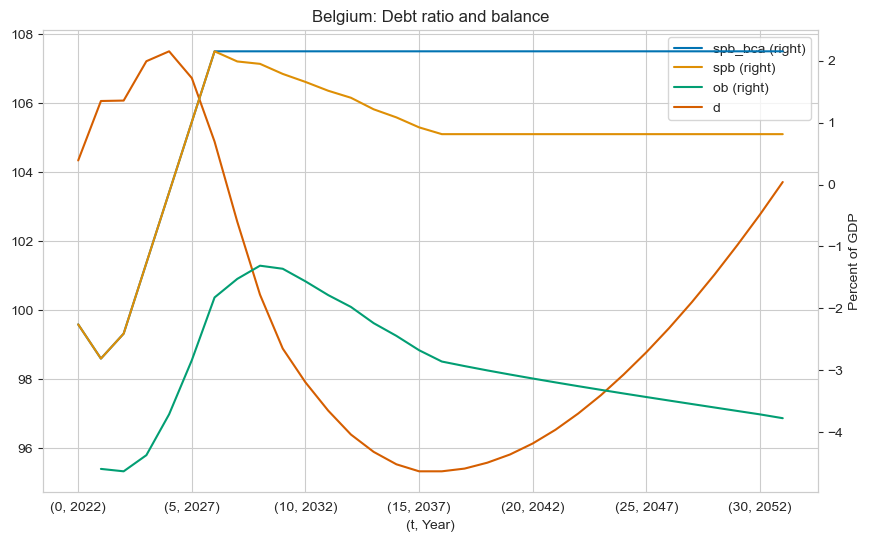

In [26]:
bel_dsa.df('spb_bca', 'spb',  'ob', 'd').plot(
    title='Belgium: Debt ratio and balance', 
    secondary_y=['spb', 'spb_bca', 'ob'], 
    ylabel='Percent of GDP', 
    xlabel='(t, Year)', 
    legend=True, 
    figsize=(10, 6))

### Stochastic Optimization

The StochasticDsaModel class is a subclass of the DsaModel and inherits all its functionalities. It is initiated analogously.

The latest update introuces a number f addiitonal parameters that can be altered to test model assumptions. These include:
- "ageing_cost_period" to specify the post-adjustment window during which ageing costs are seperated out from SPB 
- "shock_frequency" to specify the underlying shock data frequenct as "quarterly" or annual"
- "shock_sample_start" for the start of the sampled shock data
- "stochastic_start_year" for the start of the fanchart, ie the period form which unceirtainty is incorporated into projections

In [65]:
esp_sdsa = StochasticDsaModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [66]:
esp_sdsa.project()
esp_sdsa.simulate(N=1000000)

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio. If the save_df option is specified, we can access the underlying percentile data as new model attribute. The period parameter determines the number of projection periods. The Commission methodology uses 5.

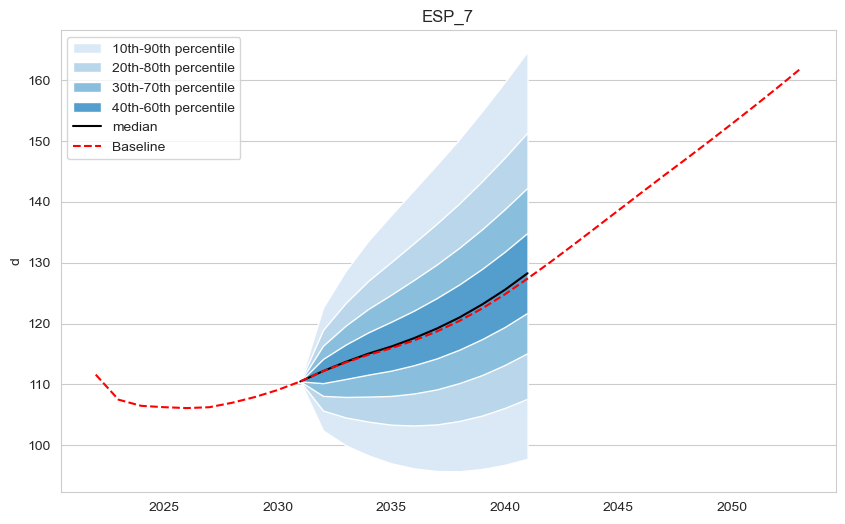

In [30]:
esp_sdsa.fanchart(variable='d', periods=10)

In [31]:
esp_sdsa.df_fanchart.dropna()

year  baseline     p10     p20     p30     p40     p50     p60     p70  \
9   2031   110.496 110.496 110.496 110.496 110.496 110.496 110.496 110.496   
10  2032   112.169 102.457 105.720 108.128 110.220 112.196 114.198 116.371   
11  2033   113.612  99.995 104.580 107.953 110.905 113.714 116.563 119.684   
12  2034   114.877  98.345 103.899 108.009 111.623 115.073 118.582 122.435   
13  2035   115.954  97.047 103.396 108.115 112.274 116.229 120.312 124.756   
14  2036   117.232  96.218 103.263 108.522 113.165 117.603 122.134 127.186   
15  2037   118.695  95.783 103.435 109.188 114.284 119.181 124.186 129.701   
16  2038   120.449  95.740 104.010 110.232 115.726 121.004 126.449 132.477   
17  2039   122.487  96.108 104.898 111.555 117.462 123.148 129.005 135.508   
18  2040   124.808  96.796 106.153 113.213 119.458 125.551 131.829 138.819   
19  2041   127.401  97.801 107.661 115.155 121.792 128.279 134.926 142.344   

       p80     p90  
9  110.496 110.496  
10 118.961 122.635  
11 123.405 128.701  
12 127.049 133.645  
13 130.116 137.858  
14 133.223 141.971  
15 136.402 146.100  
16 139.762 150.336  
17 143.412 154.923  
18 147.293 159.699  
19 151.431 164.752

The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing. The probability target and the period over whcih the fanchart and the criterion are applied can be changed from their default values.

In [32]:
esp_sdsa.find_spb_stochastic(prob_target=0.3, stochastic_criterion_period=5)

2.0059764970210843

### Integrated optimization

To quickly calculate all scenarios and detmerine which is binding, we can call the "find_spb_binding" method. Note that this method is only available after initalizing a stochastic model. \
The method determines optimal SPB targets for all deterministic and stochastic DSA criteria, as well as for the 3% deficit criteria. If no spcified differently, the method then checks whether the EDP or either of the two safeguards, the debt and the deficit resilience safeguard, are violated and corrects the binding SPB target accordingly.

In [72]:
esp_sdsa.find_spb_binding(save_df=True, edp=True, debt_safeguard=True, deficit_resilience=True)


________________________ Optimizing ESP 7-year ________________________
SPB*: 2.1571999999998233 (adverse_r_g)
SPB* after EDP for adverse_r_g: 2.1571999999998233
EDP not binding
SPB* after binding debt safeguard: 2.6727999999998335
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 1.637499999999834


'Binding SPB target: 2.6727999999998335 (debt_safeguard)'

The "find_spb_binding" method saves a dictionaries with the binding targets and timeseries for all scenarios. In addition, it saves the projection parameters of the binding scenario for quick replication.

In [43]:
esp_sdsa.spb_target_dict

{'main_adjustment': 1.4322999999998327,
 'lower_spb': 1.9177999999998327,
 'financial_stress': 1.4915999999998333,
 'adverse_r_g': 2.1571999999998233,
 'deficit_reduction': 1.6287999999998322,
 'stochastic': 2.0003876231857527,
 'debt_safeguard': 2.6727999999998335,
 'post_adjustment': 1.637499999999834,
 'binding': 2.6727999999998335}

In [44]:
esp_sdsa.df_dict['binding'].head()

d  spb_bca  spb_bca_adjustment    spb     pb     ob     sb  \
t y                                                                       
0 2022 111.618   -2.329                 NaN -2.329 -2.371    NaN    NaN   
1 2023 107.507   -2.073               0.256 -2.073 -1.639 -3.996 -4.430   
2 2024 106.493   -0.981               1.092 -0.981 -0.647 -3.063 -3.397   
3 2025 106.398   -0.459               0.522 -0.459 -0.334 -2.879 -3.004   
4 2026 105.866    0.063               0.522  0.063 -0.115 -2.802 -2.624   

        ageing_component  cyclical_component  interest_ratio  ...         D  \
t y                                                           ...             
0 2022             0.000               0.000             NaN  ... 1,502.804   
1 2023             0.000               0.432           2.357  ... 1,558.772   
2 2024             0.000               0.334           2.416  ... 1,621.158   
3 2025             0.000               0.127           2.545  ... 1,679.185   
4 2026             0.000              -0.174           2.687  ... 1,724.900   

        D_lt_inst    D_st      D_lt  amortization  amortization_lt  \
t y                                                                  
0 2022     40.157  76.430 1,426.374           NaN              NaN   
1 2023     36.515 100.954 1,457.818       214.900          138.470   
2 2024     28.297 104.994 1,516.164       246.010          145.057   
3 2025     19.146 108.752 1,570.433       255.461          150.466   
4 2026     10.928 111.713 1,613.188       262.309          153.557   

        amortization_lt_inst  interest  interest_lt  interest_st  
t y                                                               
0 2022                 0.000       NaN          NaN          NaN  
1 2023                 3.643    34.193       33.192        1.002  
2 2024                 8.218    36.825       34.492        2.333  
3 2025                 9.150    40.225       36.342        3.882  
4 2026                 8.218    43.839       39.905        3.933  

[5 rows x 34 columns]

In [45]:
esp_sdsa.binding_parameter_dict

{'adjustment_steps': array([0.52195714, 0.52195714, 0.52195714, 0.52195714, 0.52195714,
        0.52195714, 0.52195714]),
 'spb_target': 2.6727999999998335,
 'edp_binding': False,
 'edp_steps': array([nan, nan, nan, nan, nan, nan, nan]),
 'deficit_resilience_steps': array([nan, nan, nan, nan, nan, nan, nan]),
 'post_adjustment_steps': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])}

The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
We can either call it directly by specifying an adjustment path or call it after we have optimized the path as above.

Text(0.5, 1.0, 'Spain: Probability of deficit during 7-year adjustment')

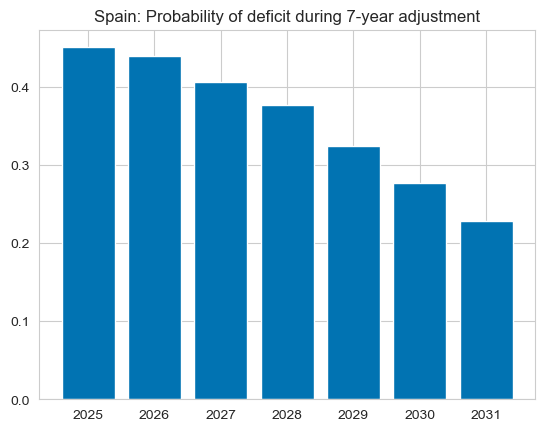

In [76]:
prob_deficit = esp_sdsa.find_deficit_prob()
plt.bar(np.arange(2025, 2032), prob_deficit)
plt.title('Spain: Probability of deficit during 7-year adjustment')

## Analysis

### Set parameters and functions

In [77]:
# List of EU codes and countries for loop and chart titles
country_code_dict = {
    'AUT': 'Austria',
    'BEL': 'Belgium',
    'CYP': 'Cyprus',
    'CZE': 'Czech Republic',
    'DEU': 'Germany',
    'DNK': 'Denmark',
    'ESP': 'Spain',
    'EST': 'Estonia',
    'FIN': 'Finland',
    'FRA': 'France',
    'GRC': 'Greece',
    'HRV': 'Croatia',
    'HUN': 'Hungary',
    'IRL': 'Ireland',
    'ITA': 'Italy',
    'NLD': 'Netherlands',
    'POL': 'Poland',
    'PRT': 'Portugal',
    'ROU': 'Romania',
    'SVK': 'Slovakia',
    'SVN': 'Slovenia',
    'SWE': 'Sweden',
    'BGR': 'Bulgaria',
    'MLT': 'Malta',
    'LUX': 'Luxembourg',
    'LTU': 'Lithuania',
    'LVA': 'Latvia'
    }
country_codes = list(country_code_dict.keys())

In [78]:
# Initialize results dictionary
results_dict = {}
for country in country_codes:
    results_dict[country] = {}
    for adjustment_period in [4, 7]:
        results_dict[country][adjustment_period] = {}

In [79]:
# Set output path and create folders if they don't exist
today = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
file_note = 'main'
output_path = f'../output/{file_note}_{today}'
if not os.path.exists(output_path):
    os.makedirs(output_path)
results_charts_path = f'{output_path}/results_charts'
if not os.path.exists(results_charts_path):
    os.makedirs(results_charts_path)

Instead of starting a new results_dict, we can also read in an existing one from the pickle in the output folder 


In [30]:
## Or read results dict from pickle in output folder 
# today = '...'
# file_note = '...'
# output_path = output_path = f'../output/{file_note}_{today}'
# results_dict = pd.read_pickle(f'{output_path}/results_dict_{today}.pkl')

In [80]:
# Call functions to run DSA (ca. 10 min for all countries)
run_dsa(
    country_codes=country_codes,
    adjustment_periods=[4, 7], 
    results_dict=results_dict, 
    output_path=output_path, 
    today=today,
    file_note=file_note,
    edp=True,
    debt_safeguard=True,
    deficit_resilience=True
    )


--> 1 of 27, estimated remaining time: 0.0 minutes

________________________ Optimizing AUT 4-year ________________________
SPB*: 1.0034999999998324 (adverse_r_g)
SPB* after EDP for adverse_r_g: 1.0034999999998324
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 0.22485999999983353

________________________ Optimizing AUT 7-year ________________________
SPB*: 1.072751685010033 (stochastic)
SPB* after EDP for stochastic: 1.108957120759862
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 0.4944771207598617

--> 2 of 27, estimated remaining time: 6.6 minutes

________________________ Optimizing BEL 4-year ________________________
SPB*: 2.151899999999812 (adverse_r_g)
SPB* after EDP for adverse_r_g: 2.151899999999812
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
SPB p

In [81]:
# Save results
save_results(
    results_dict=results_dict, 
    output_path=output_path, 
    file_note=file_note
    )

### Plot binding scenario charts

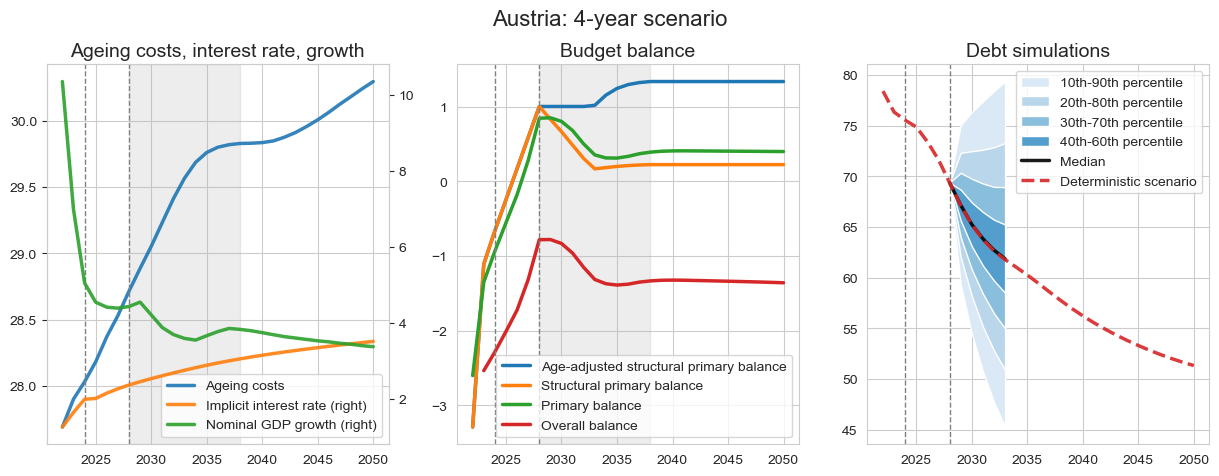

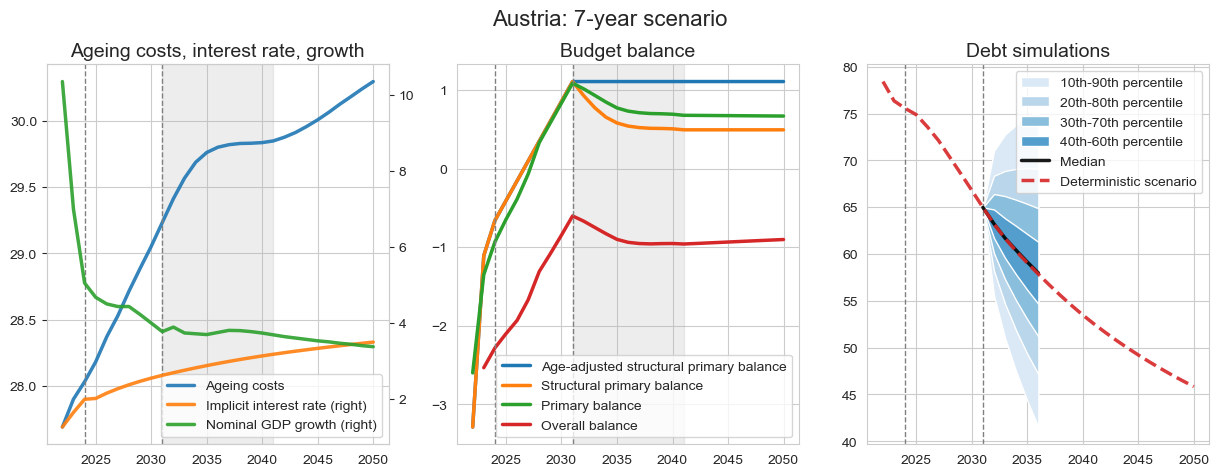

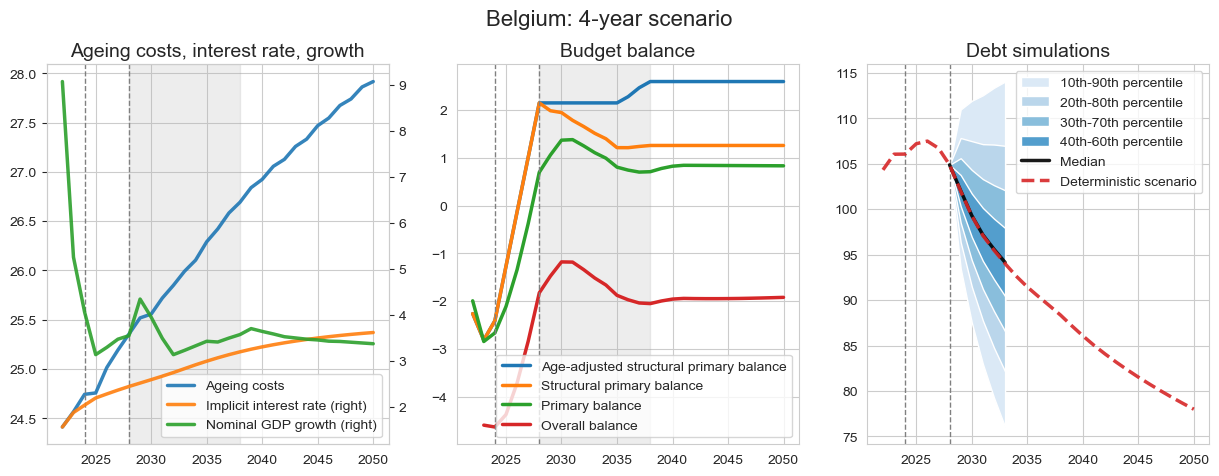

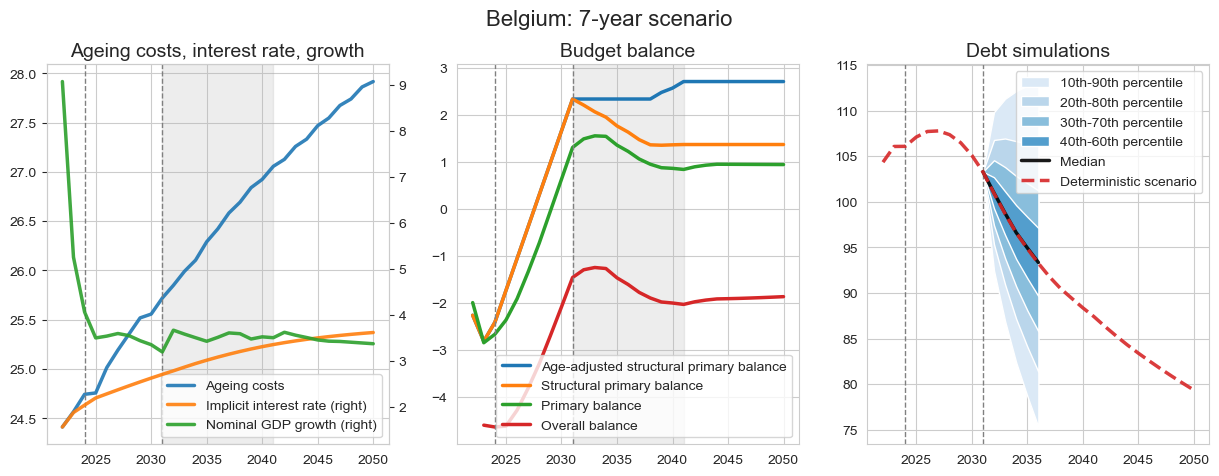

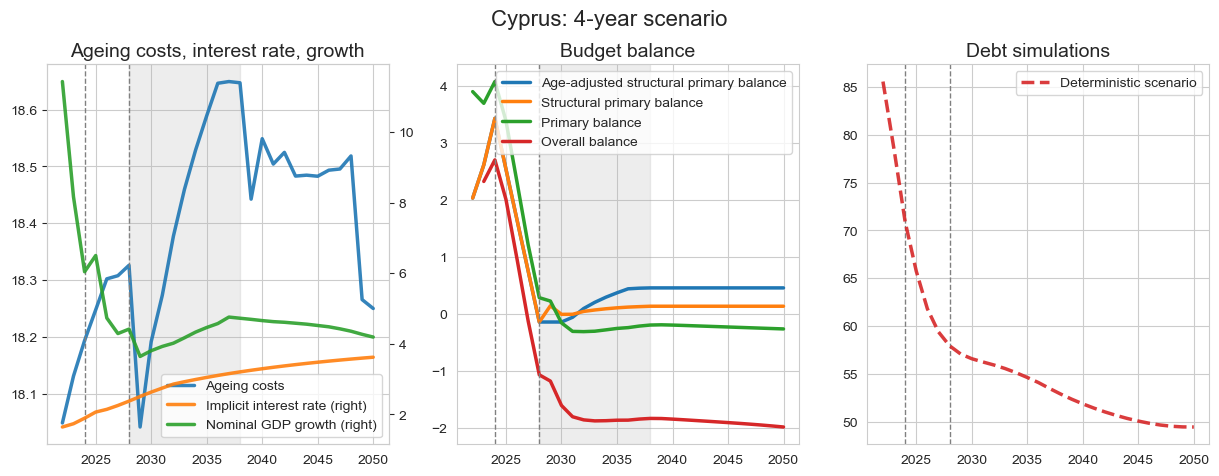

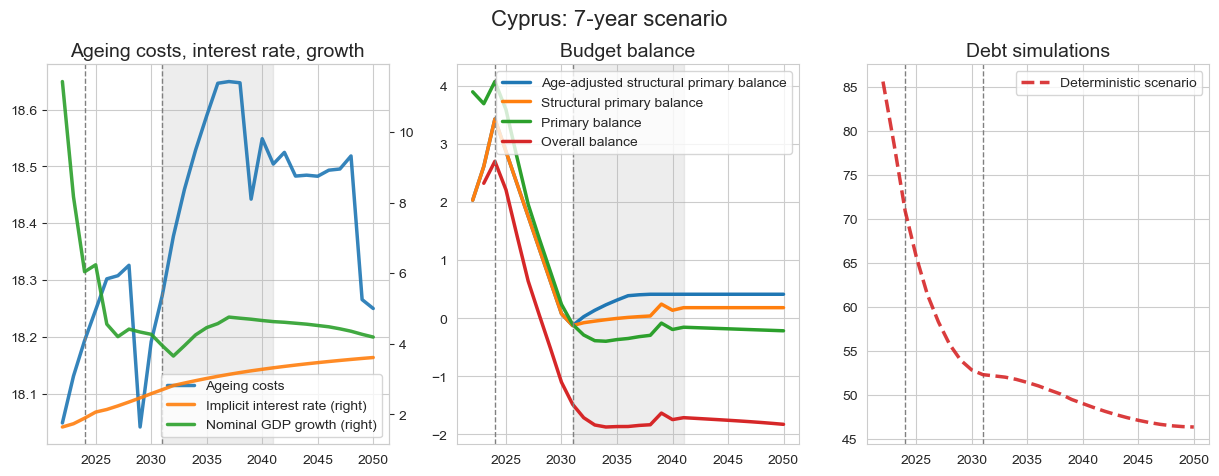

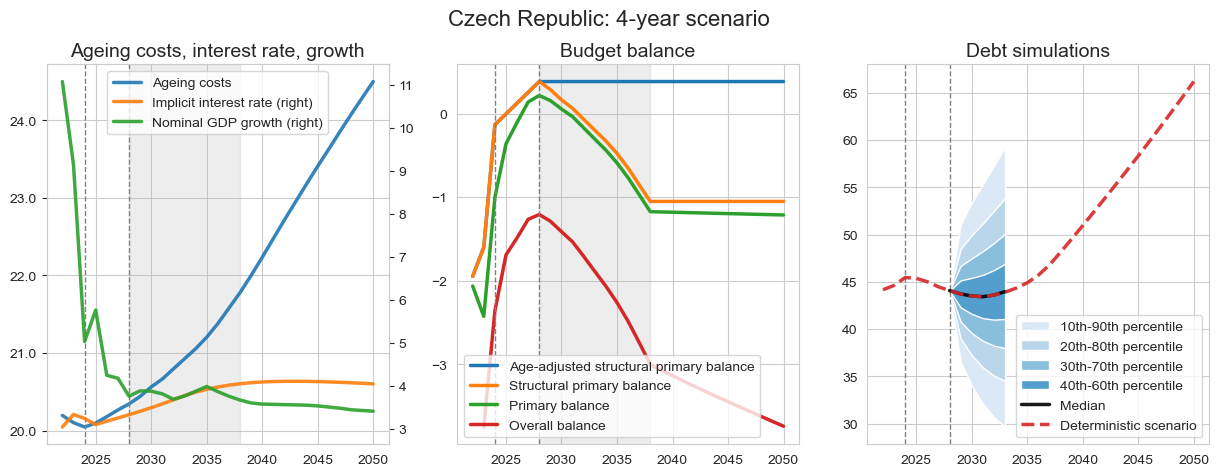

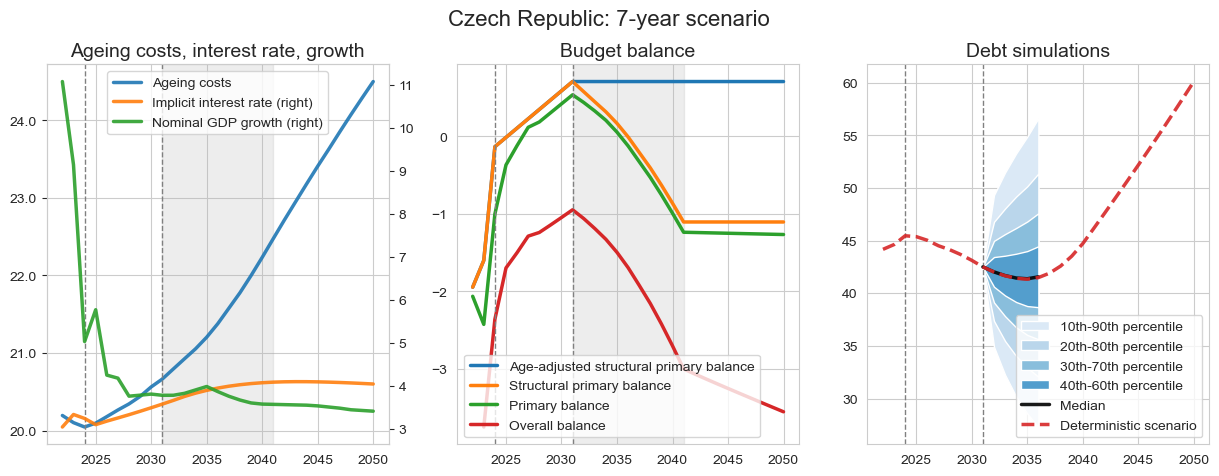

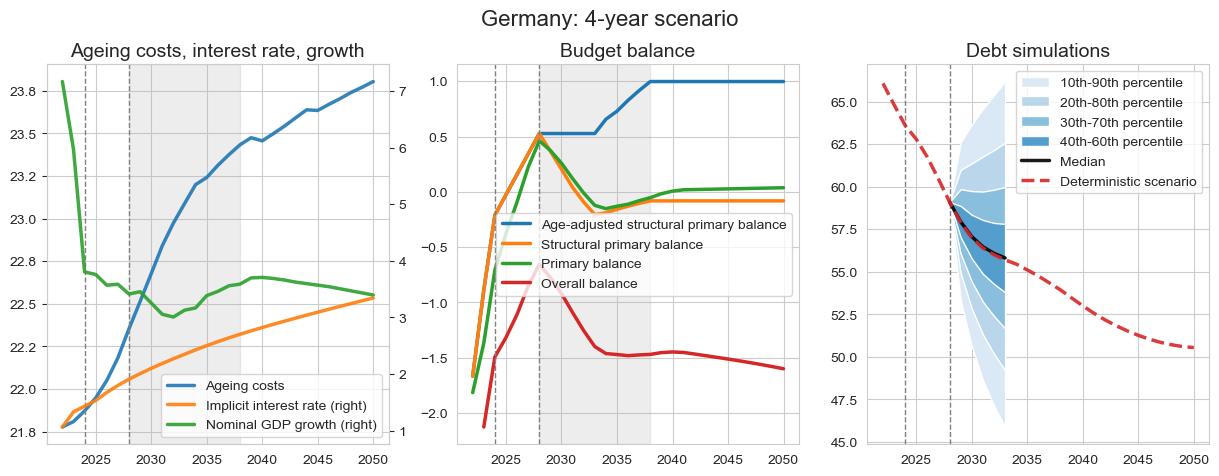

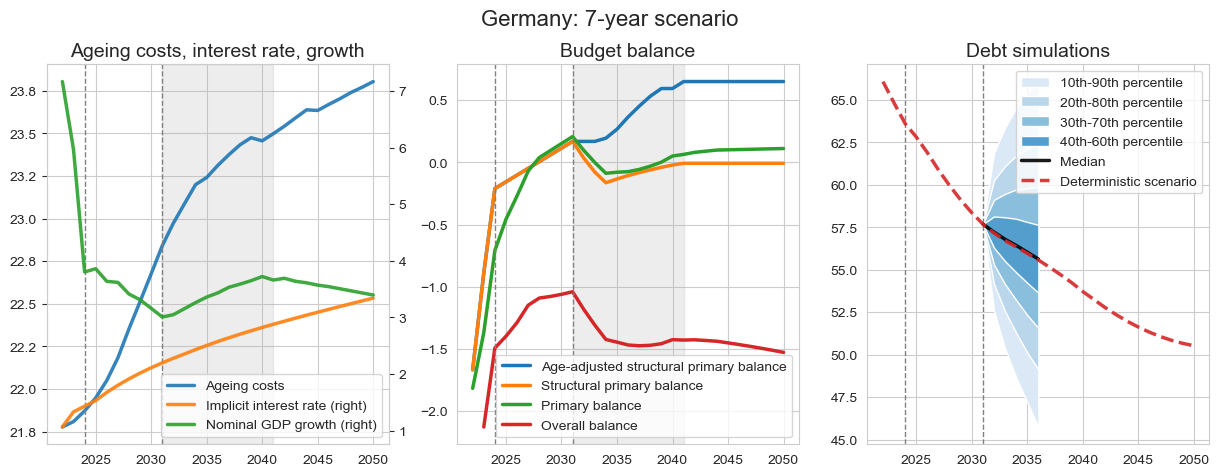

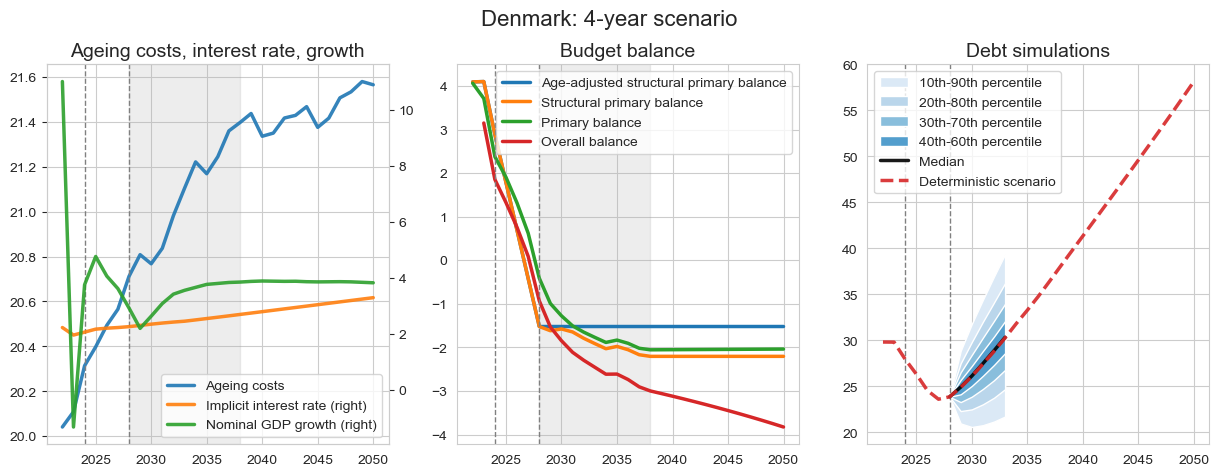

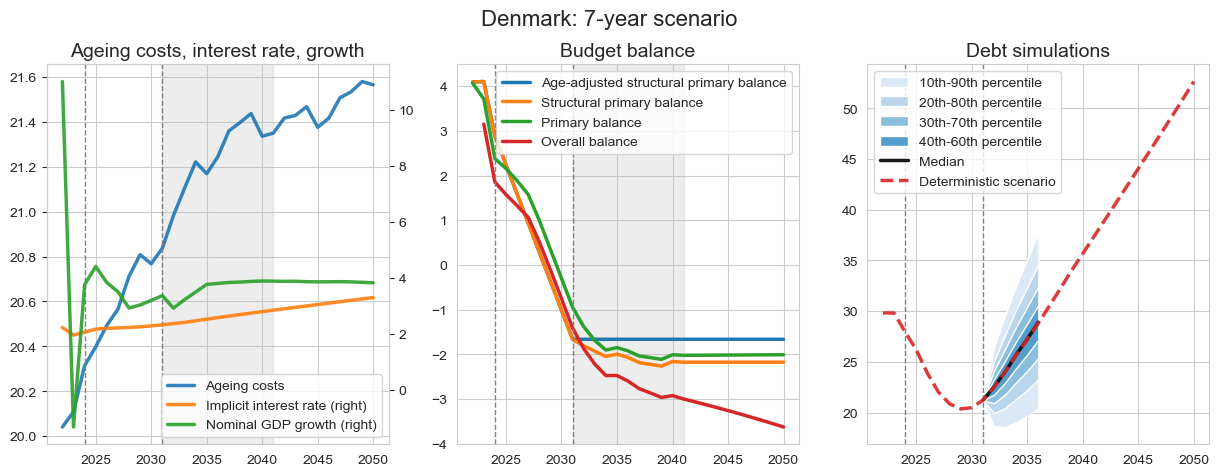

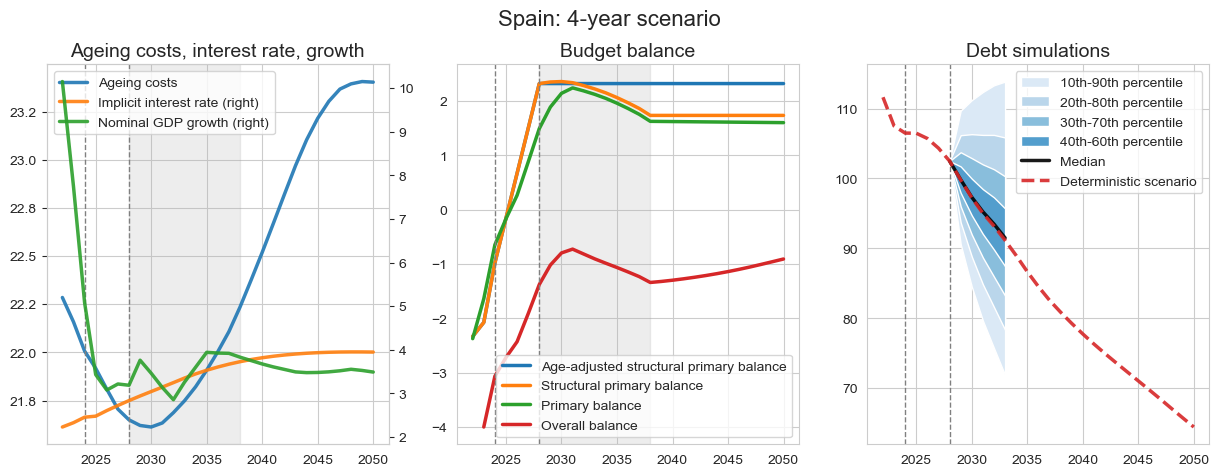

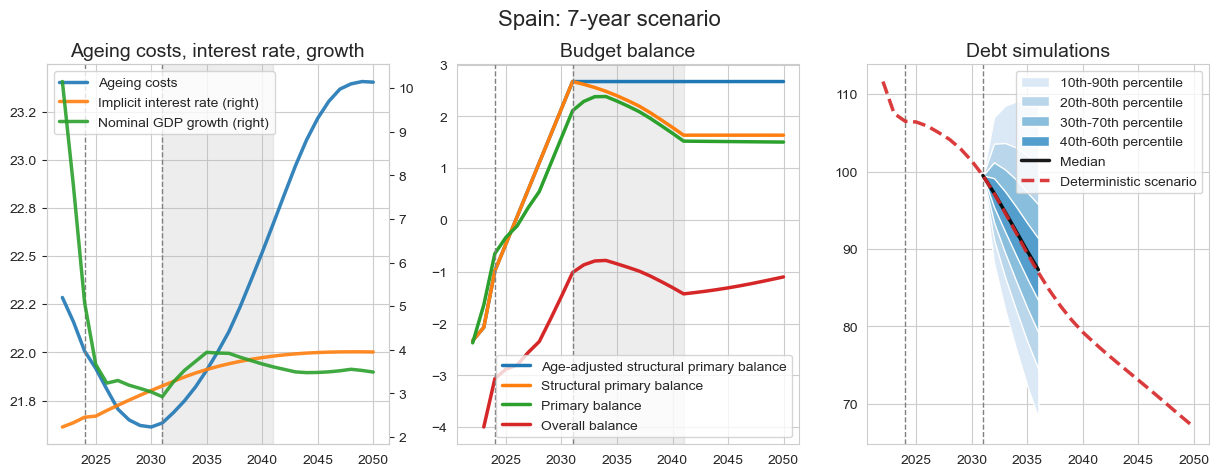

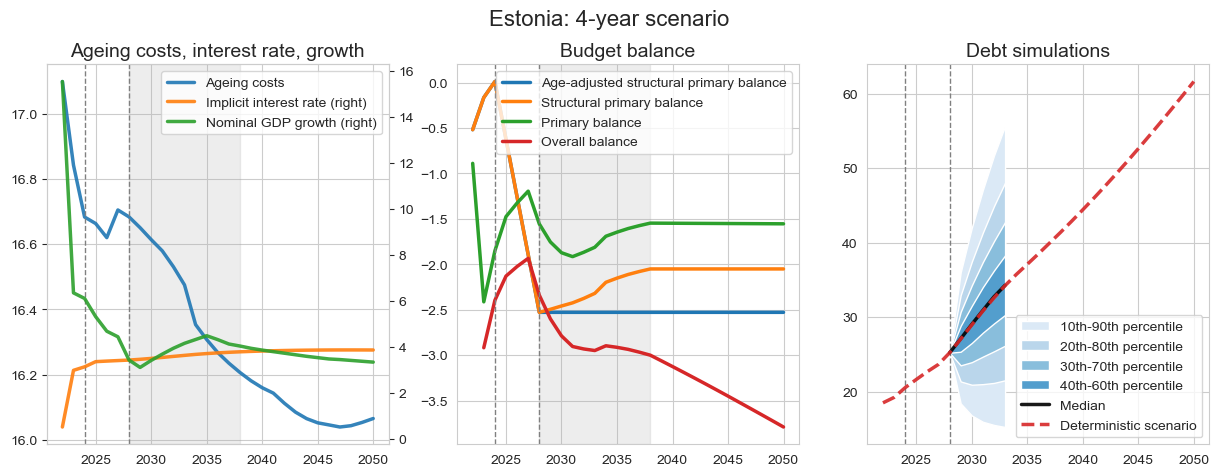

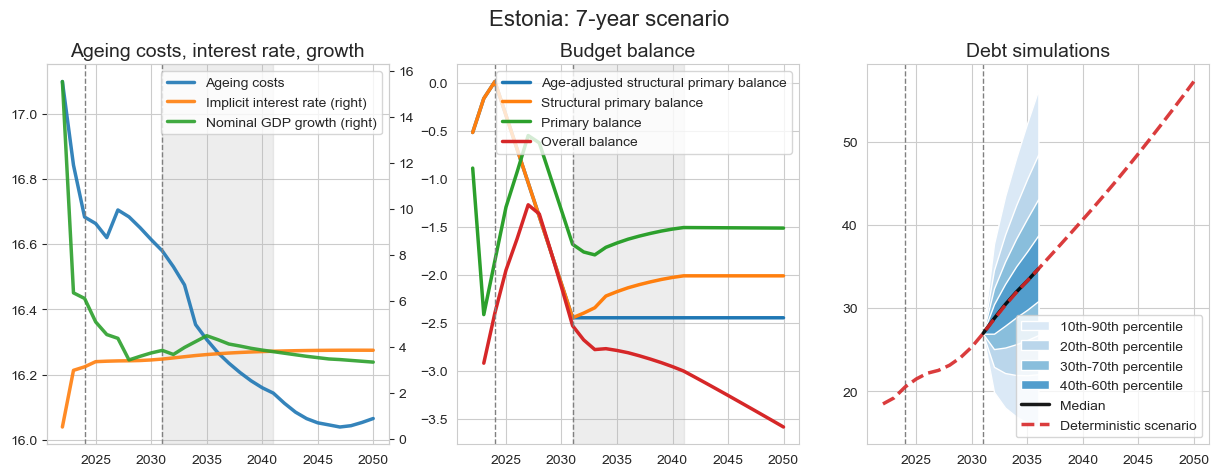

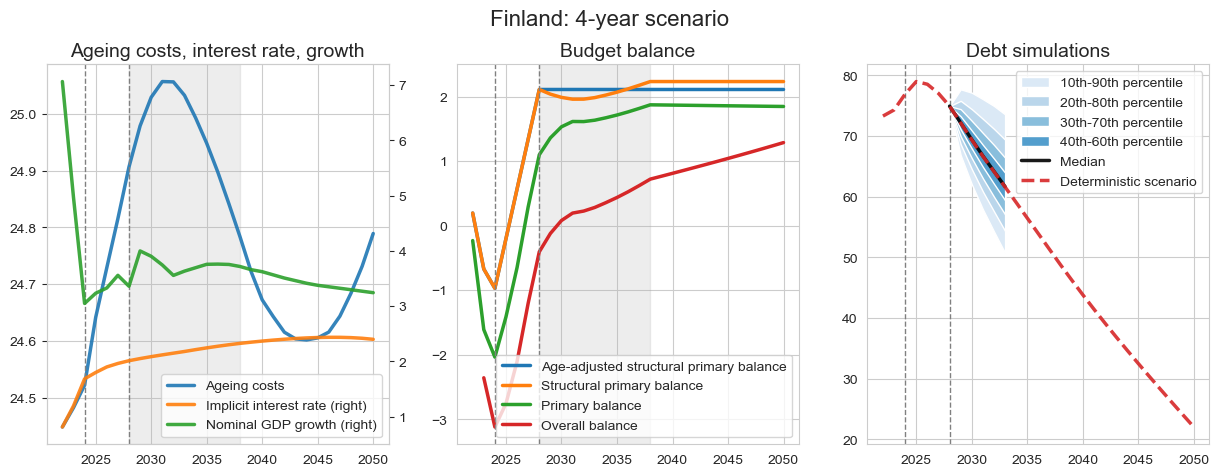

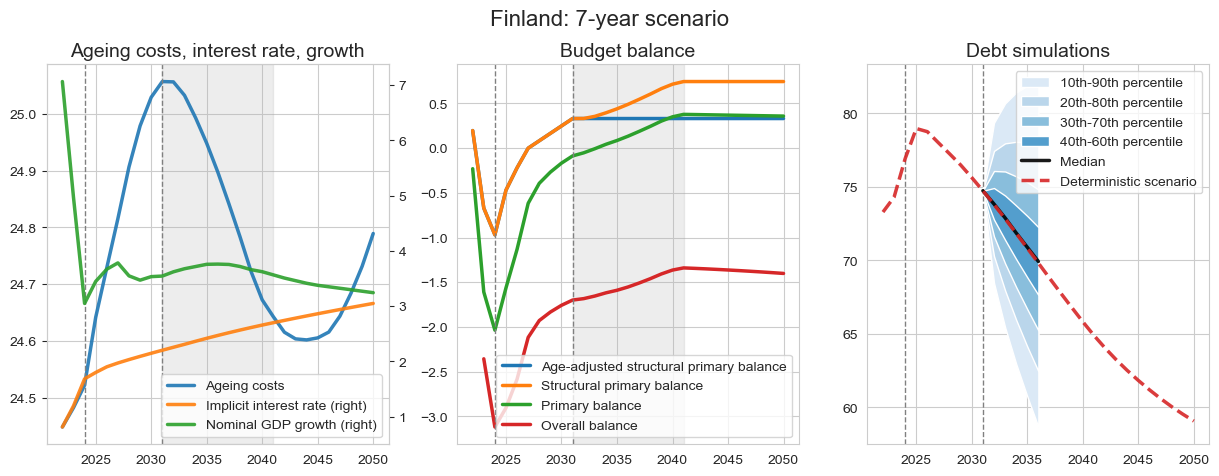

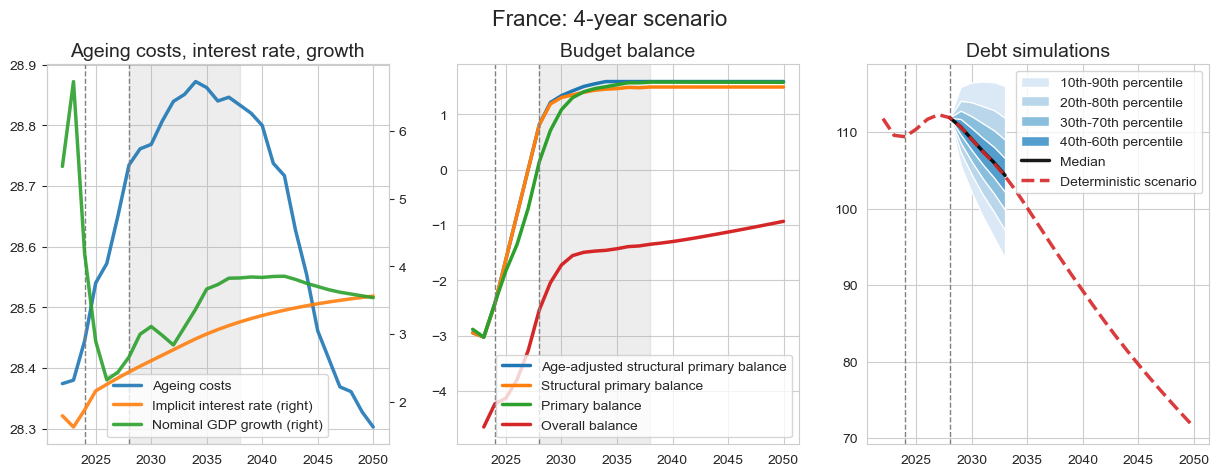

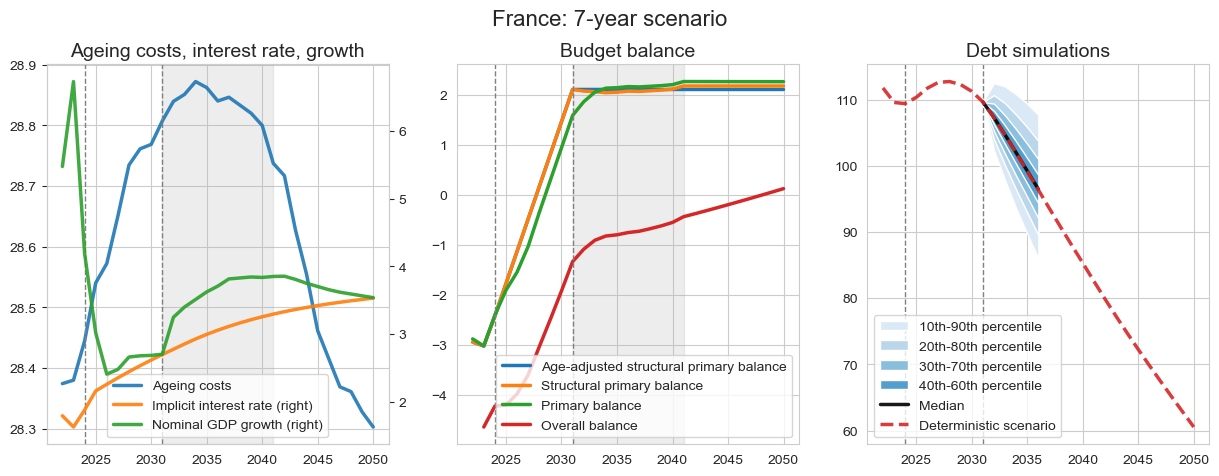

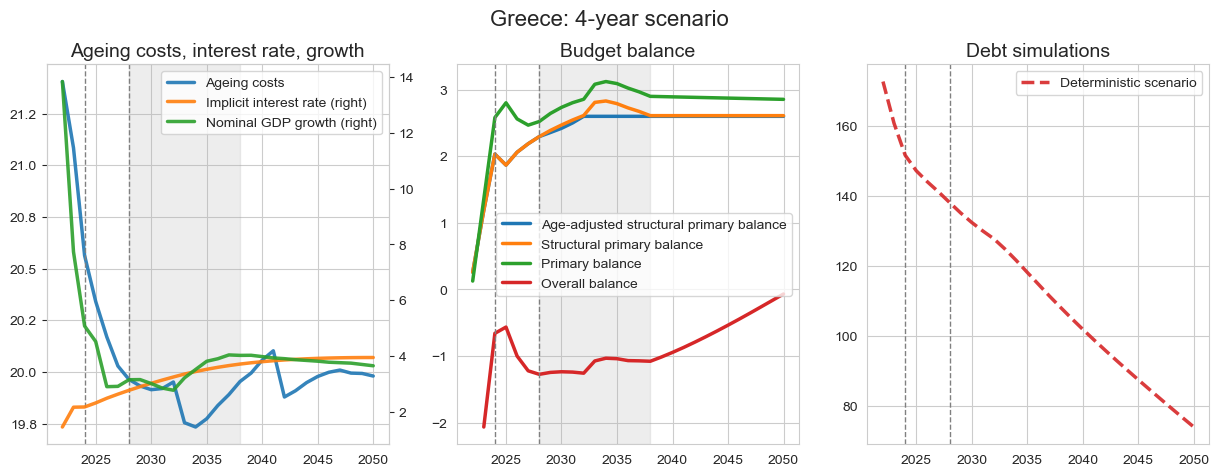

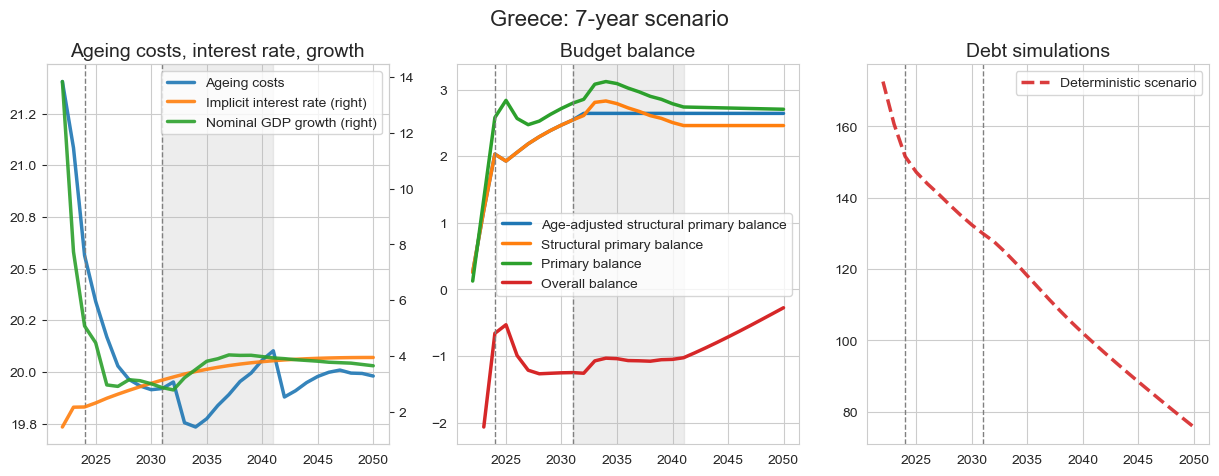

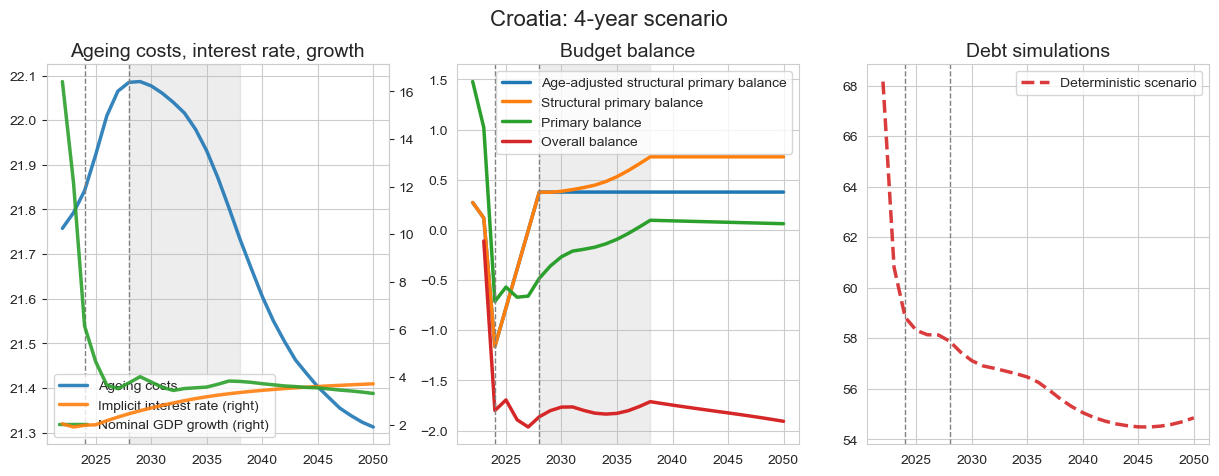

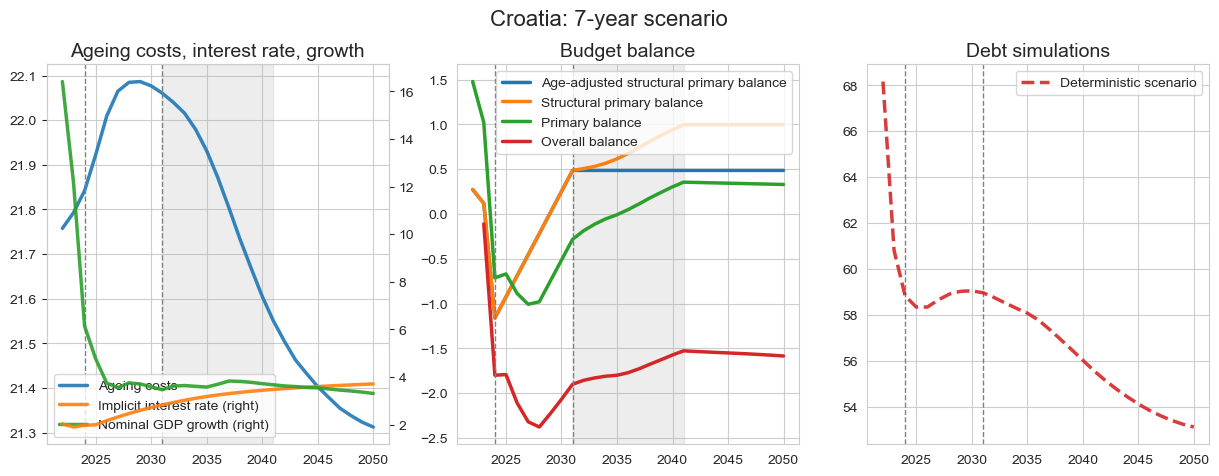

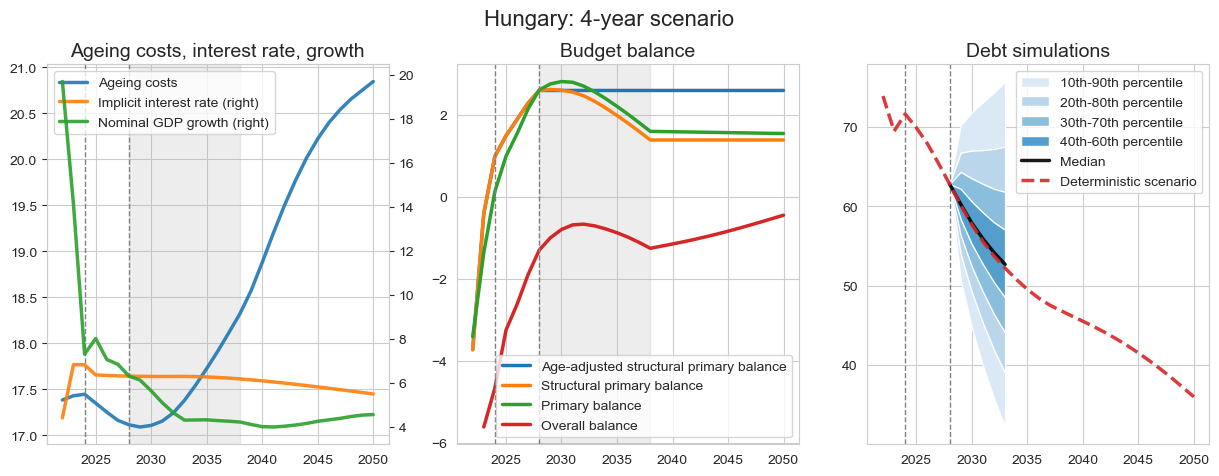

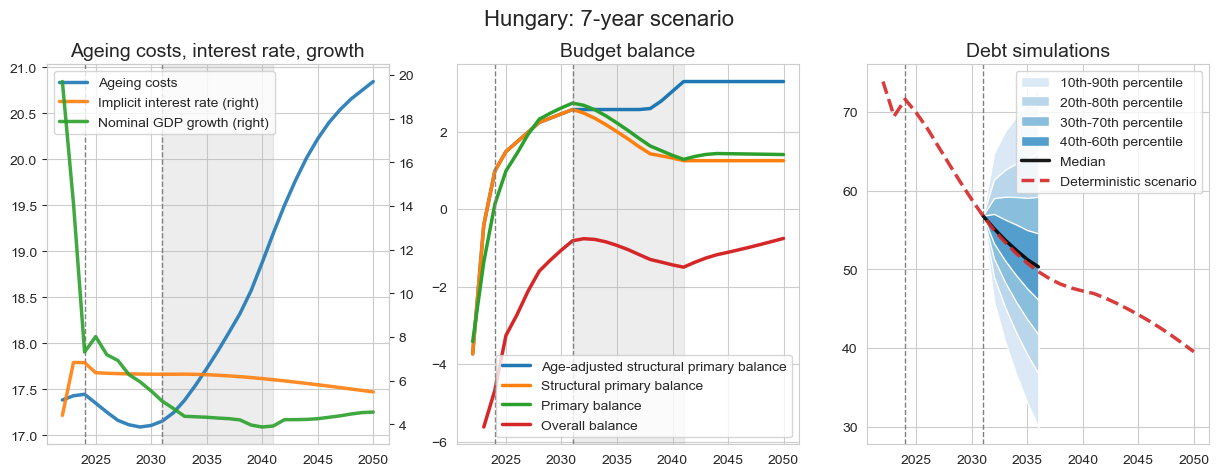

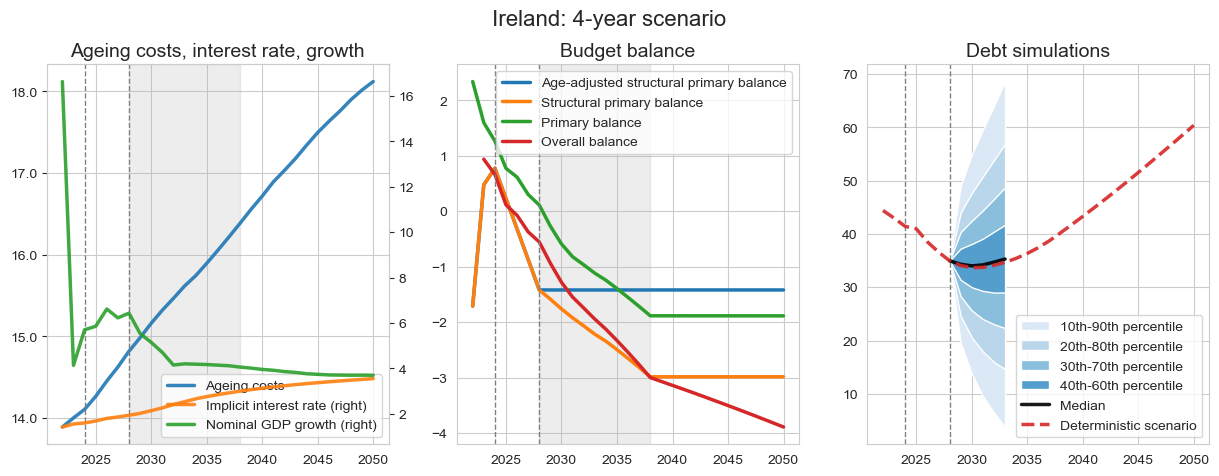

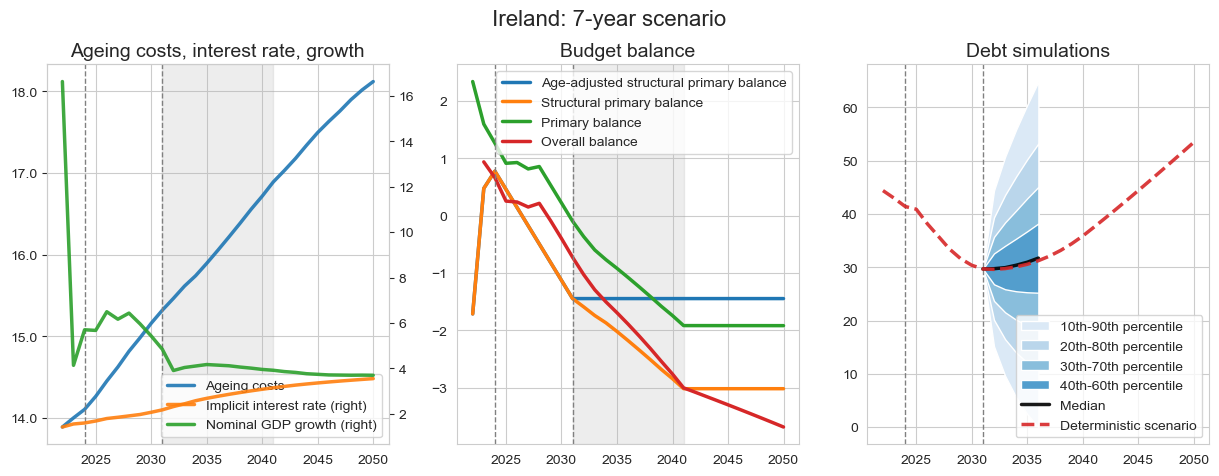

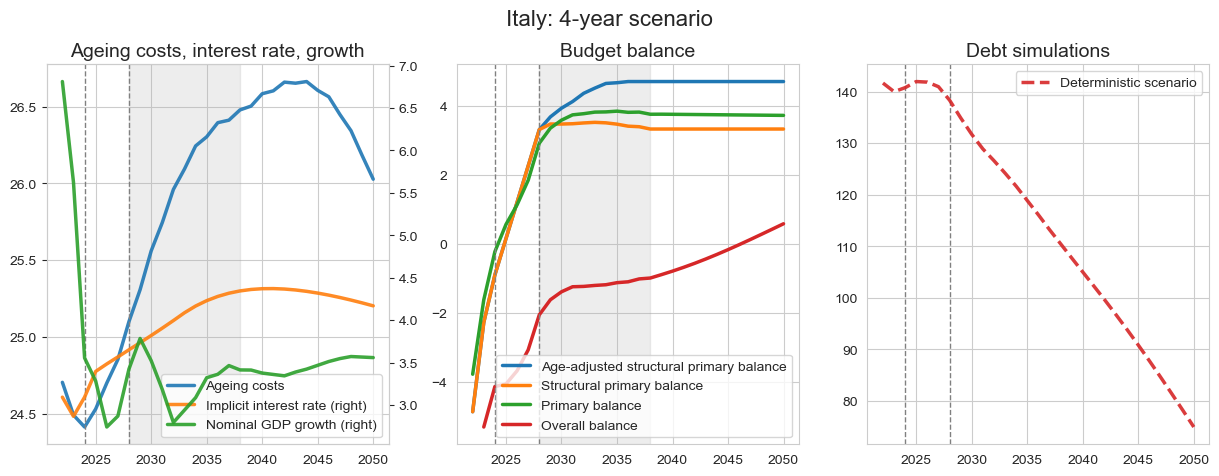

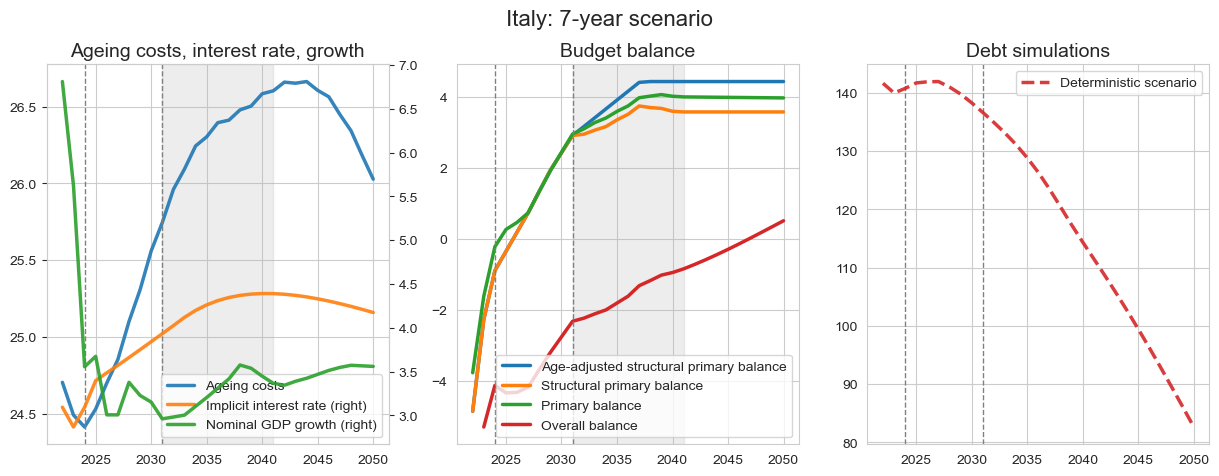

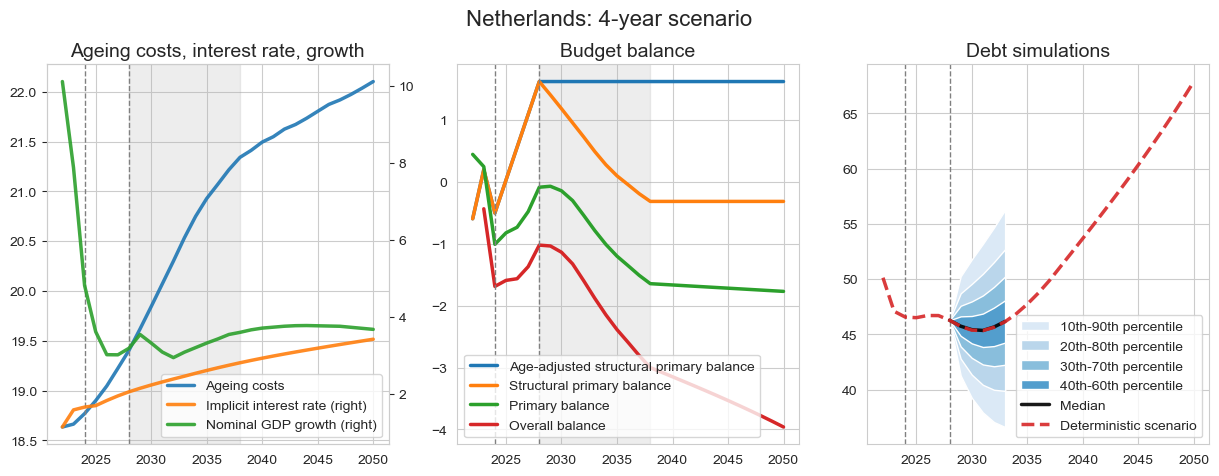

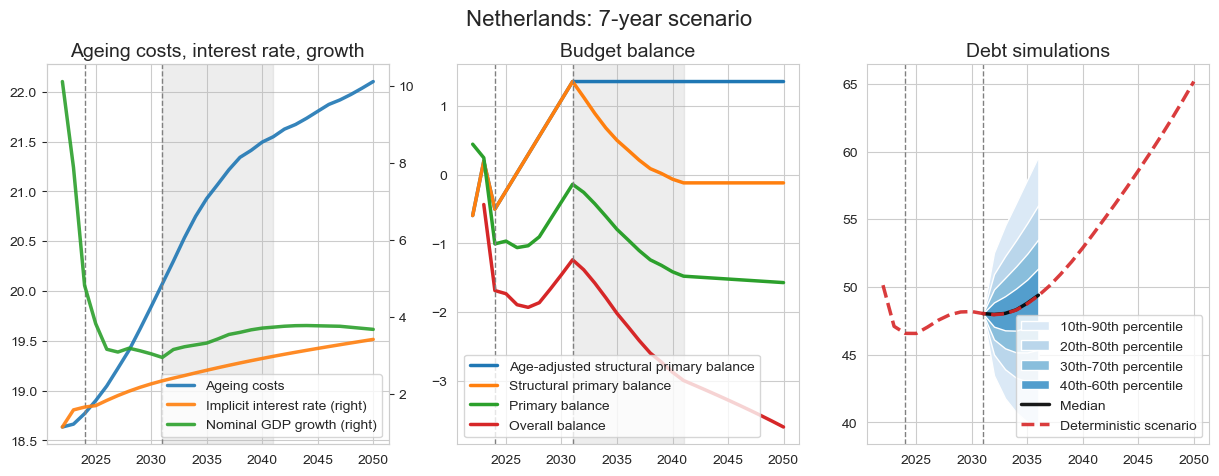

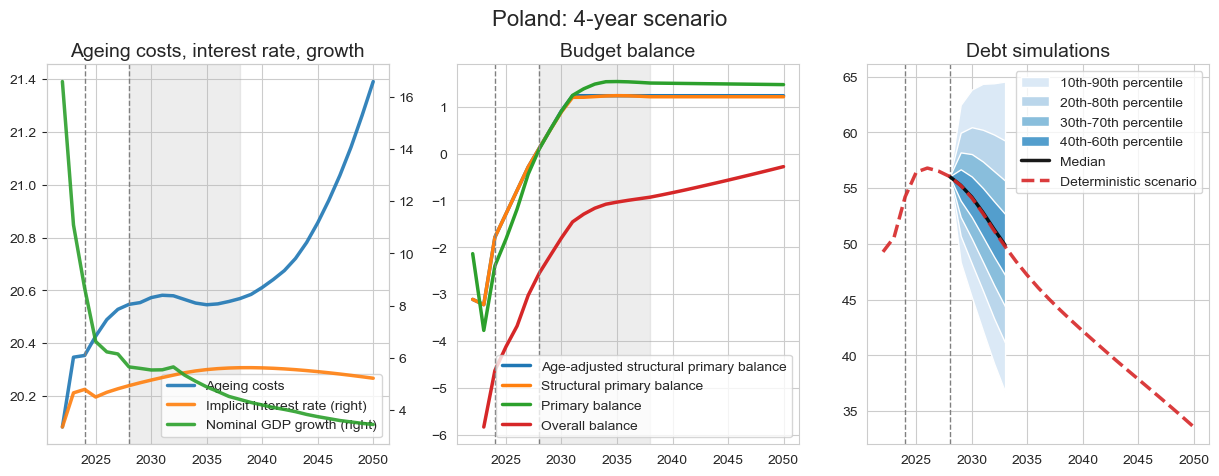

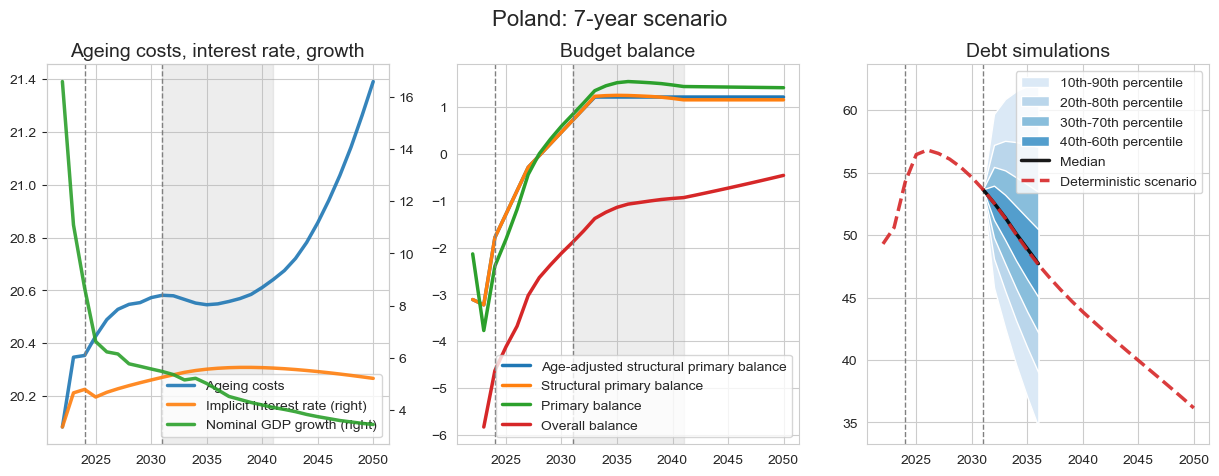

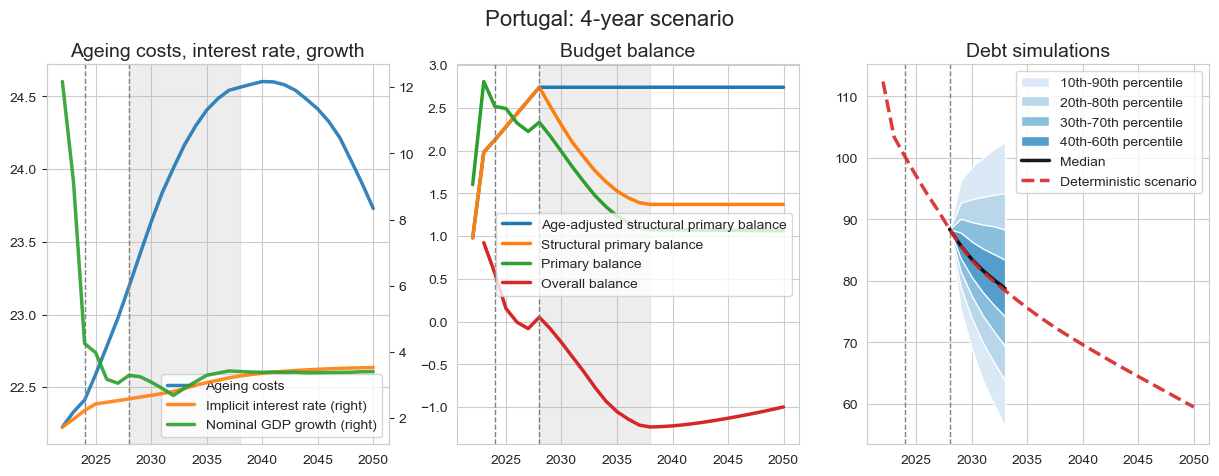

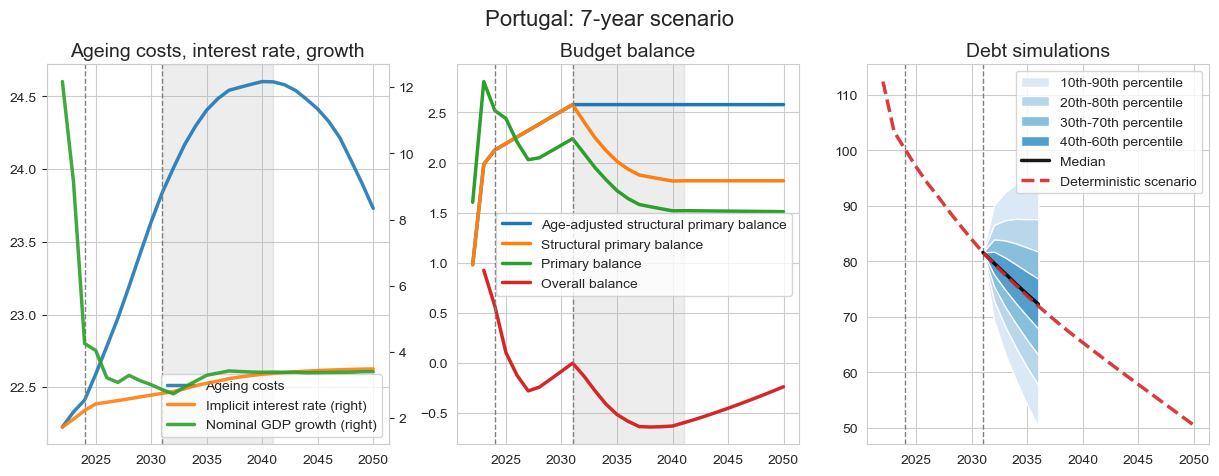

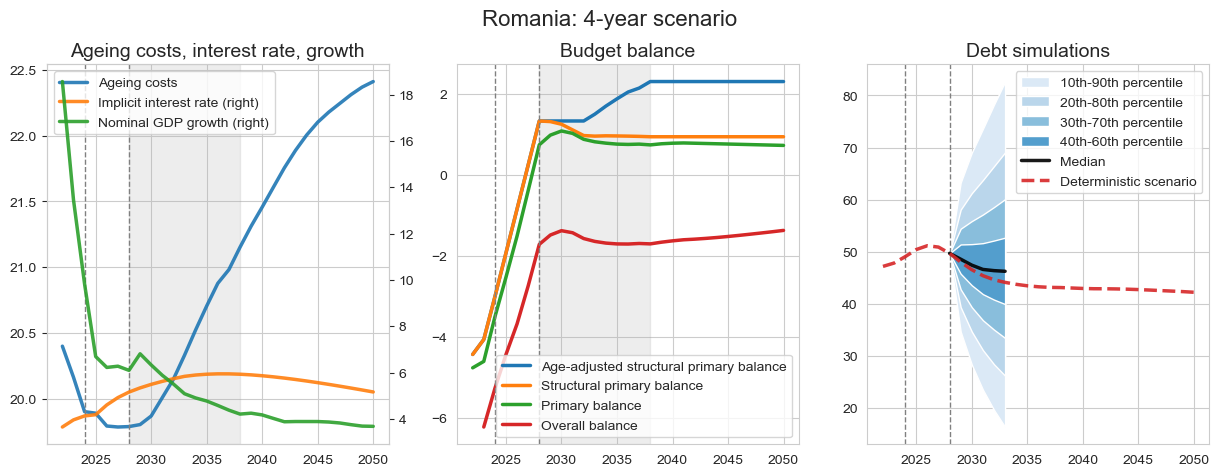

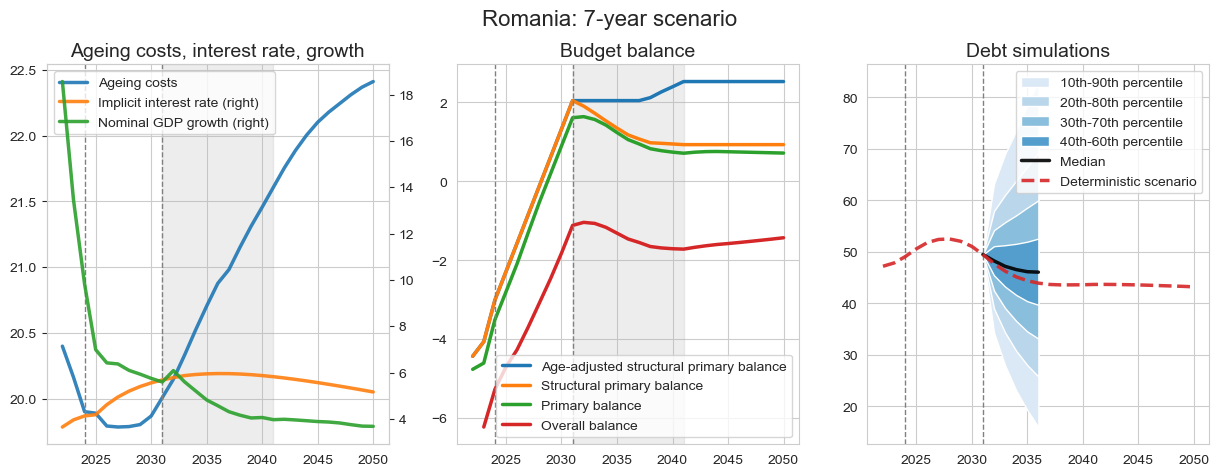

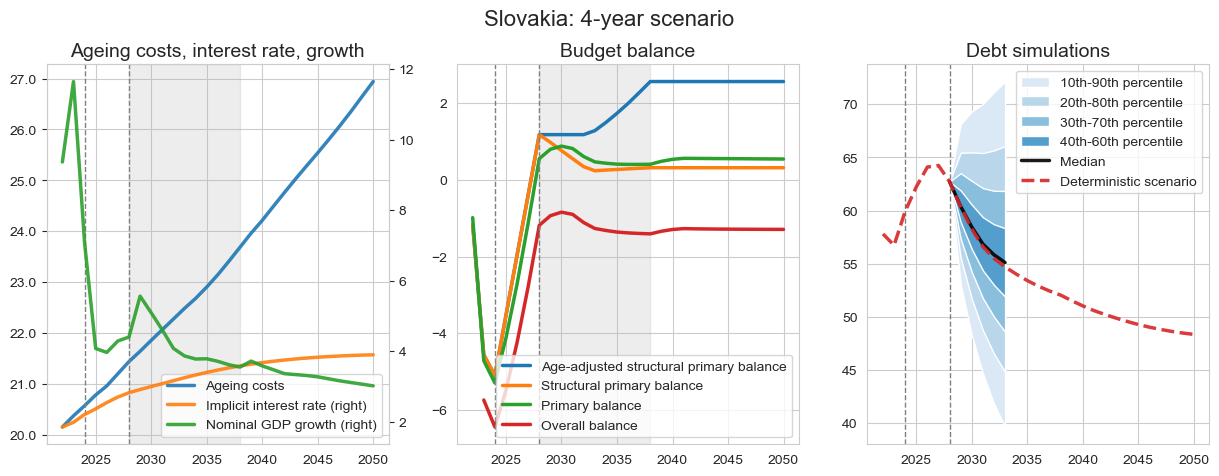

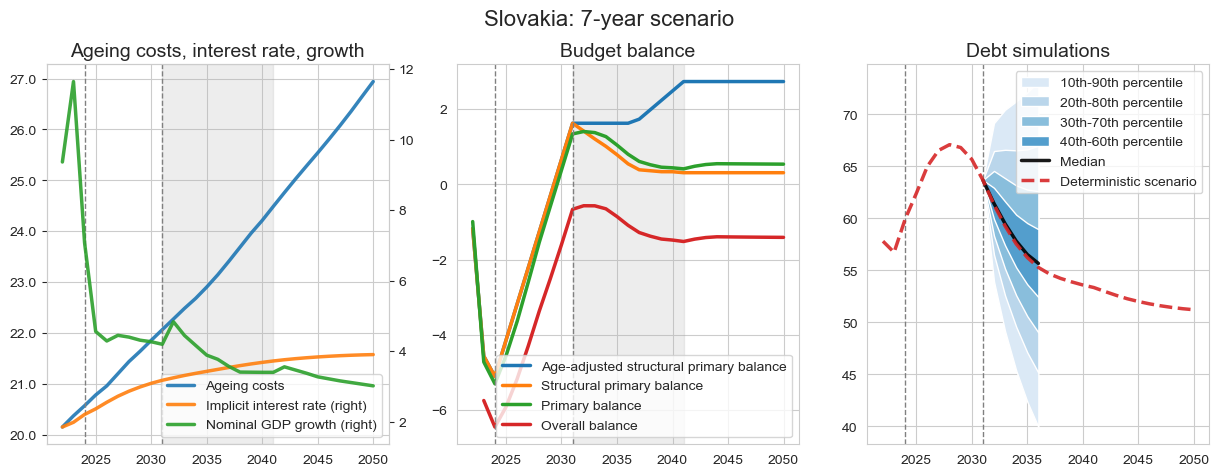

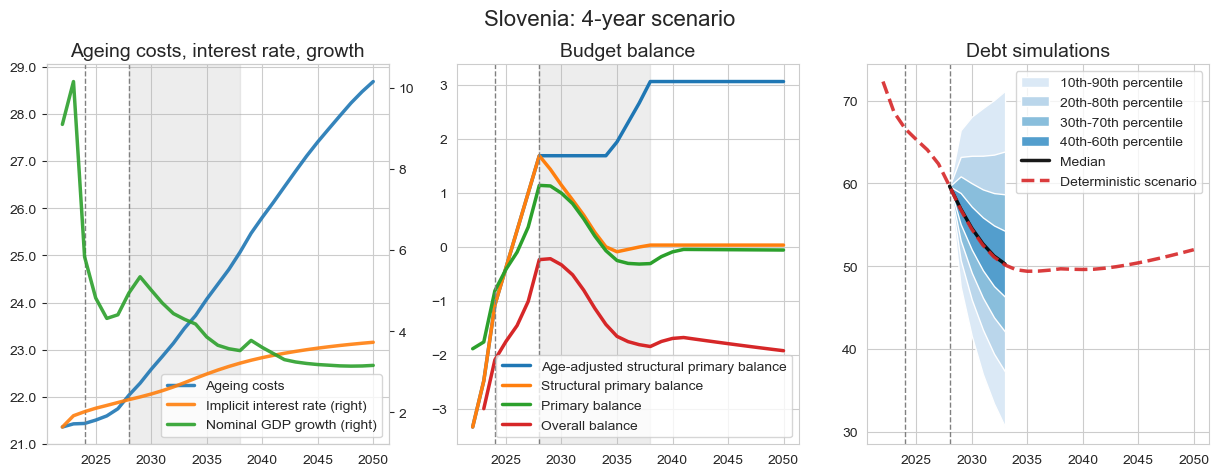

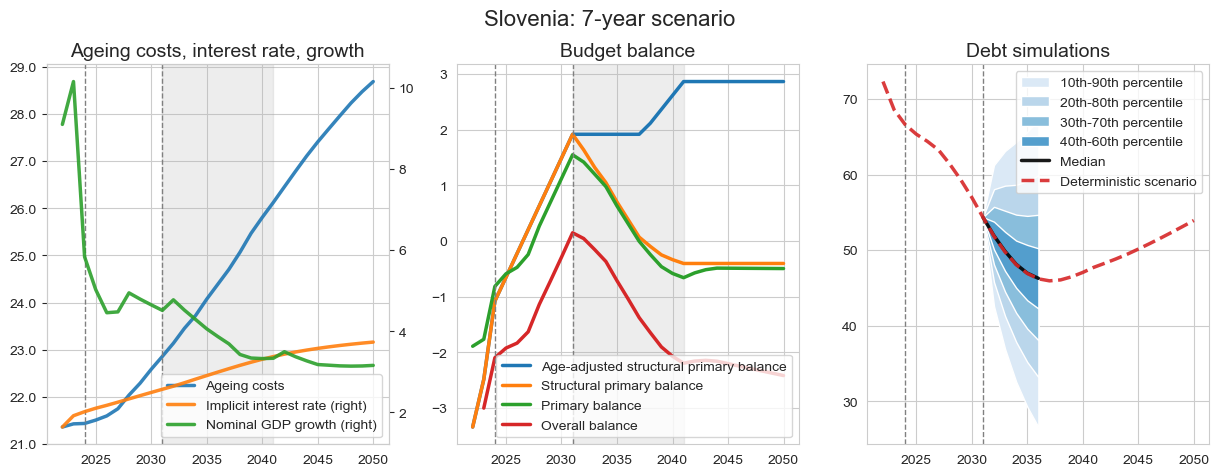

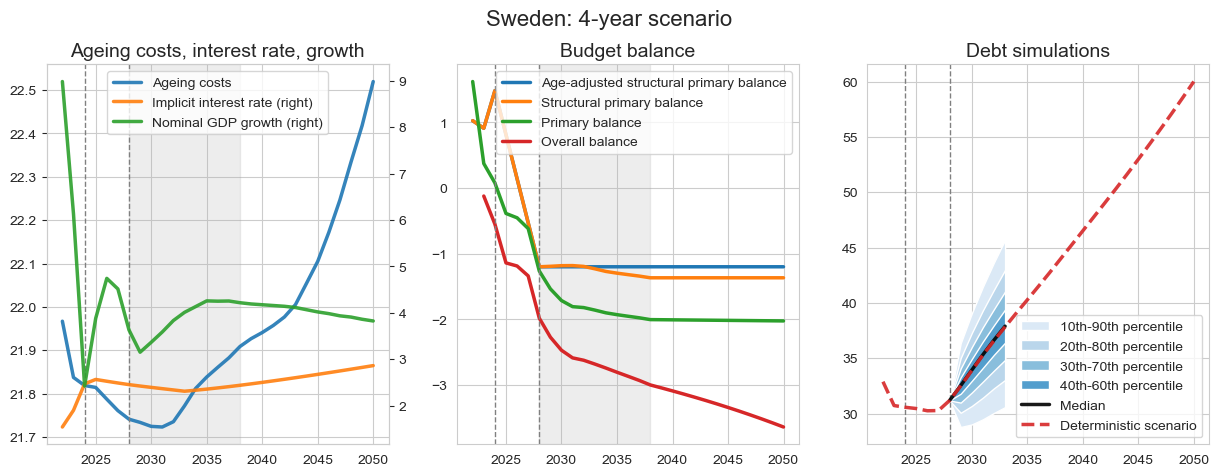

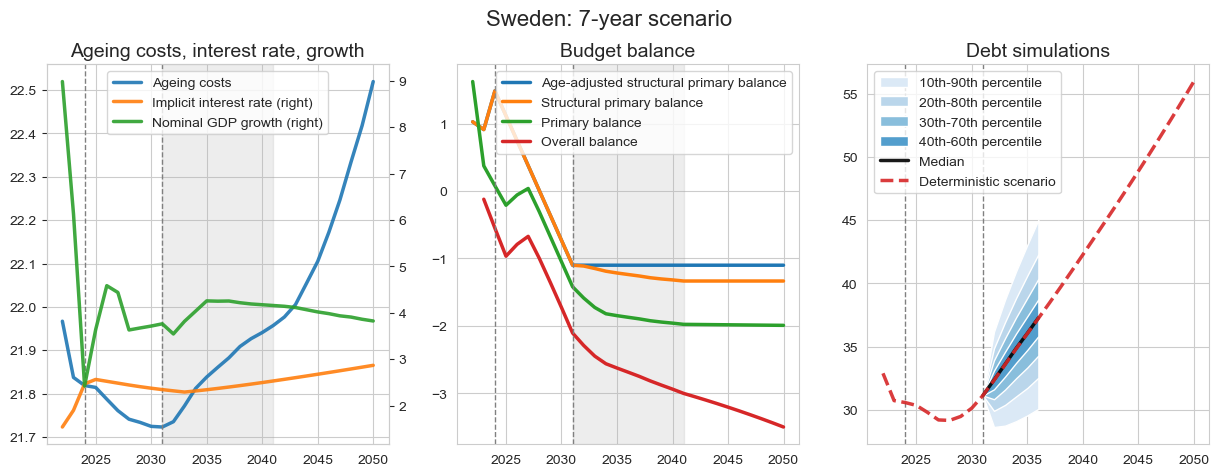

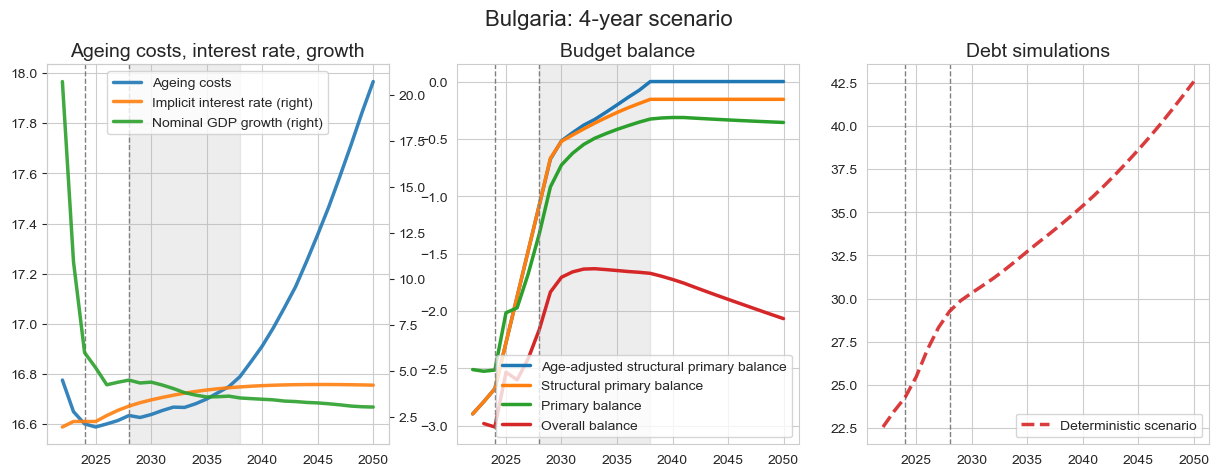

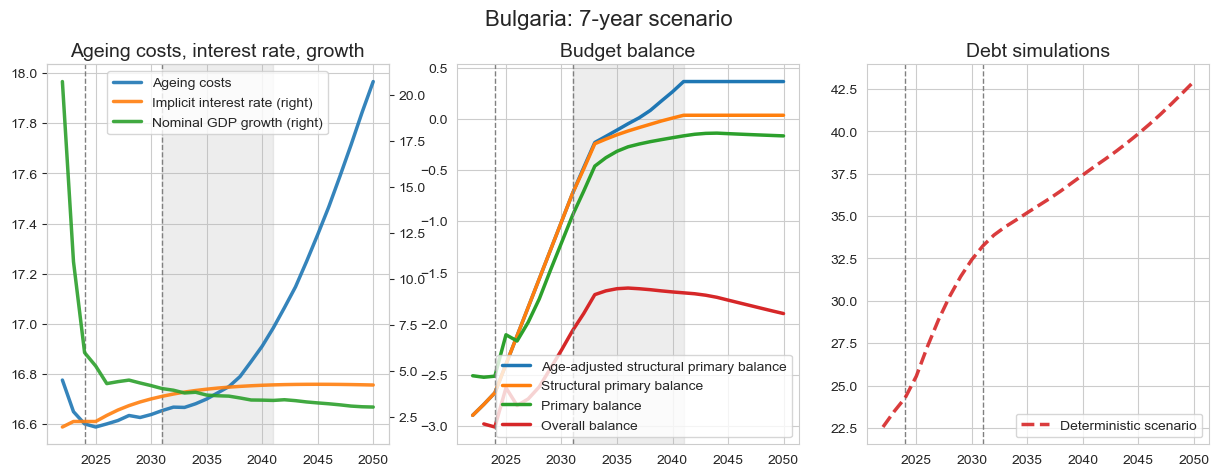

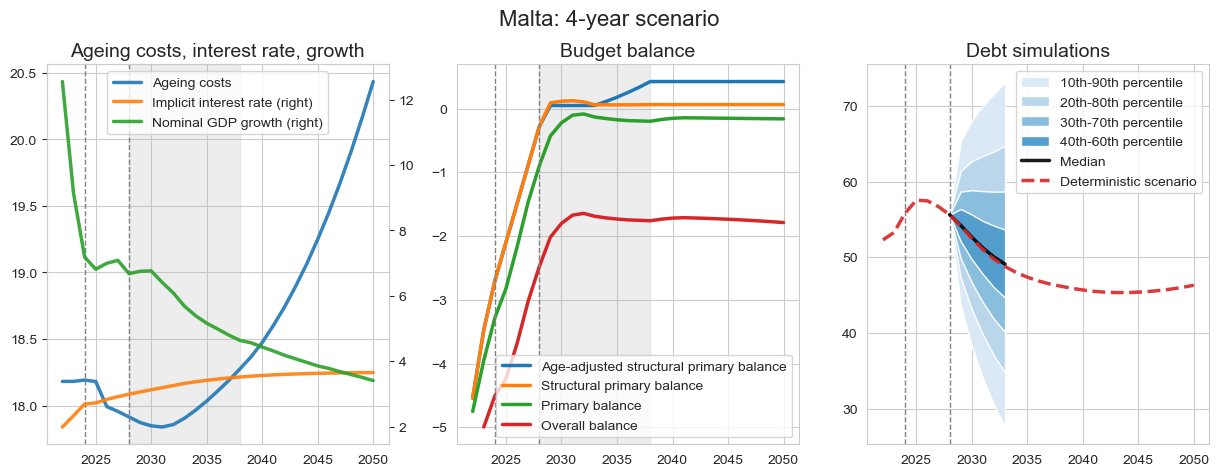

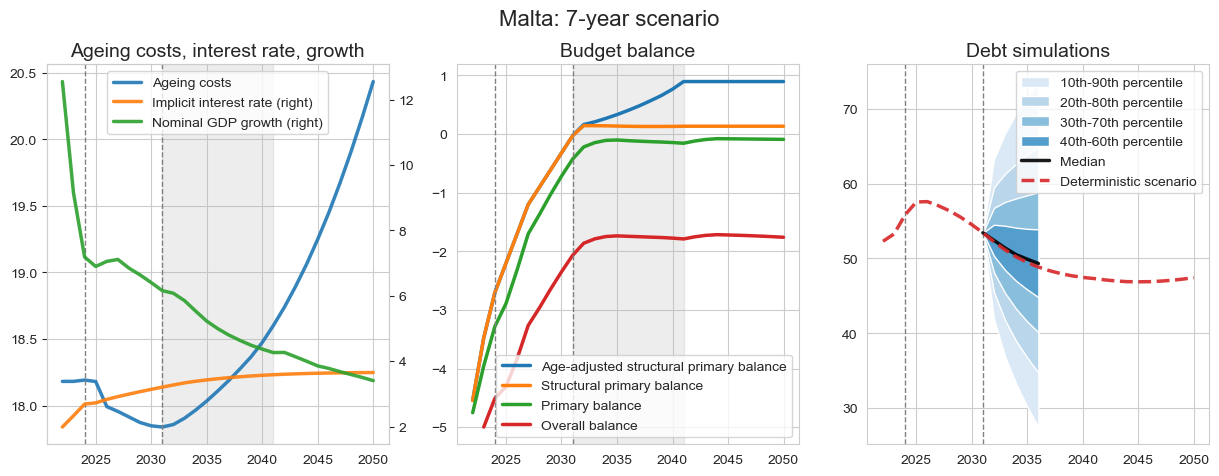

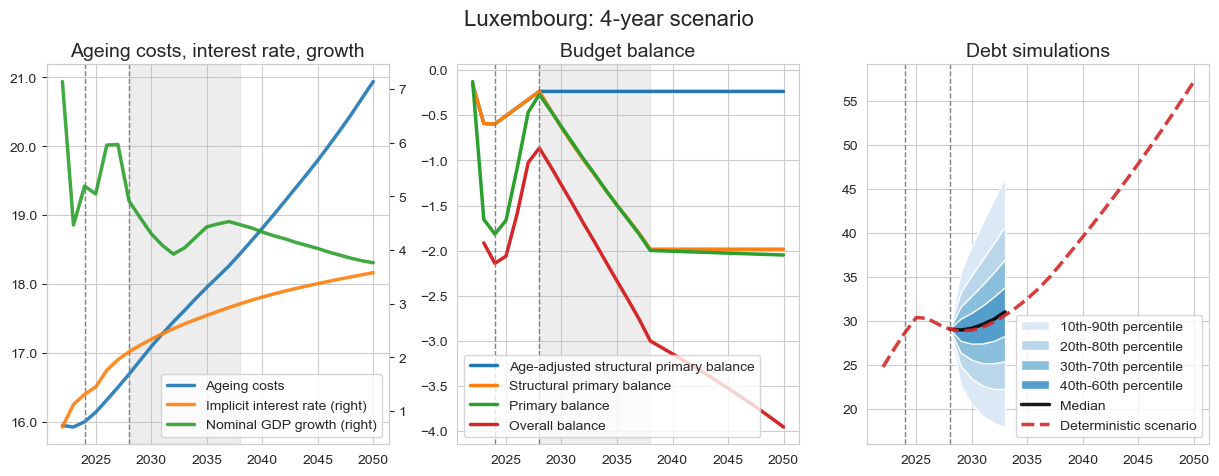

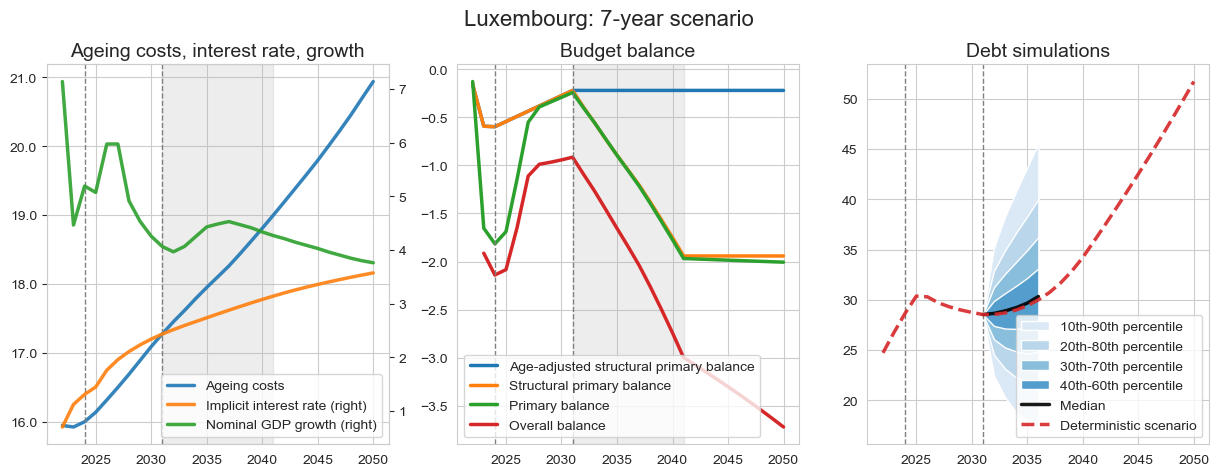

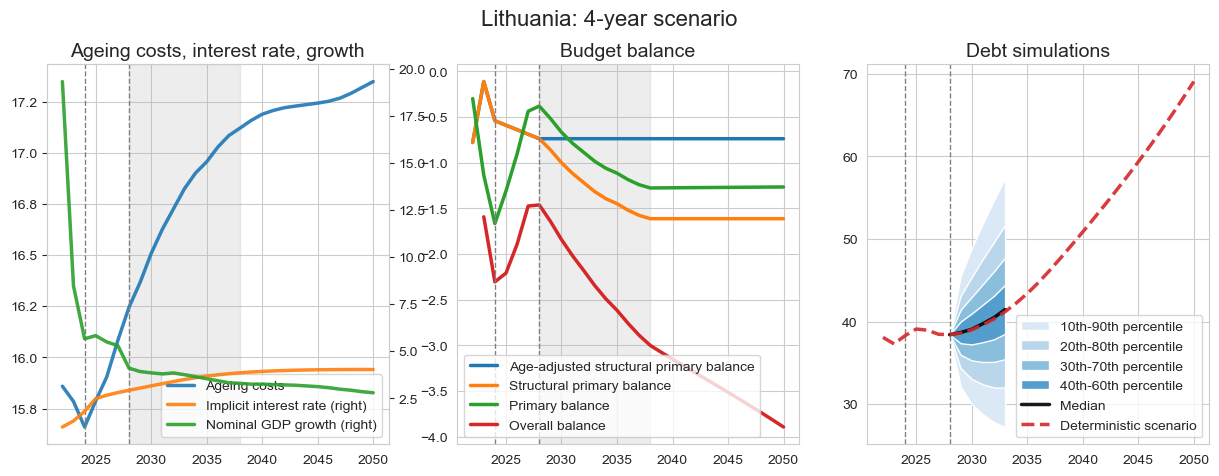

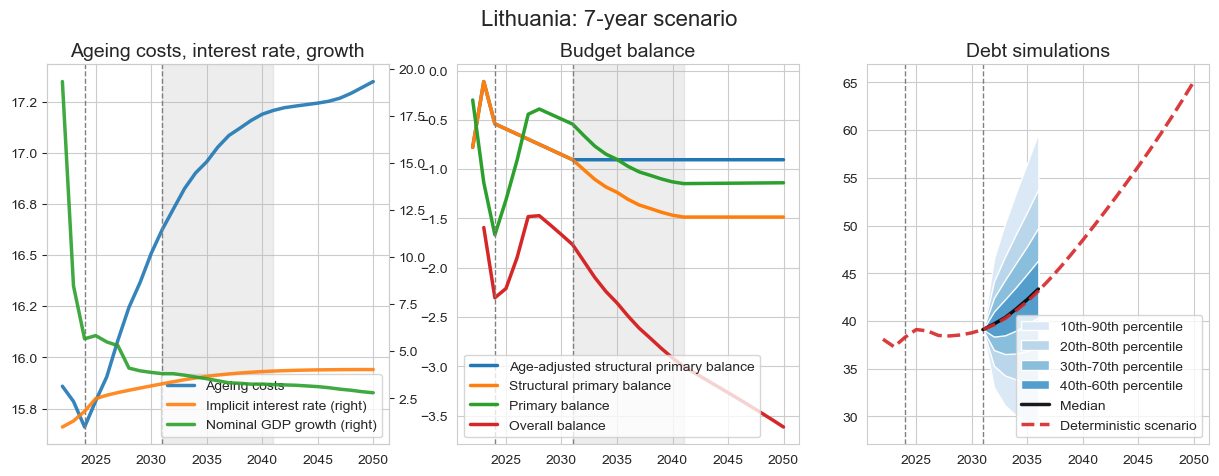

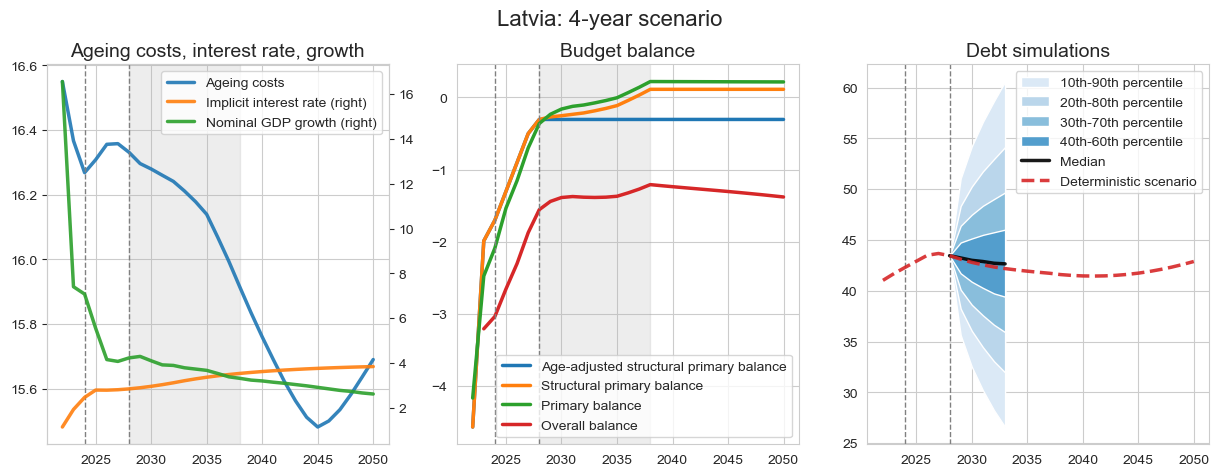

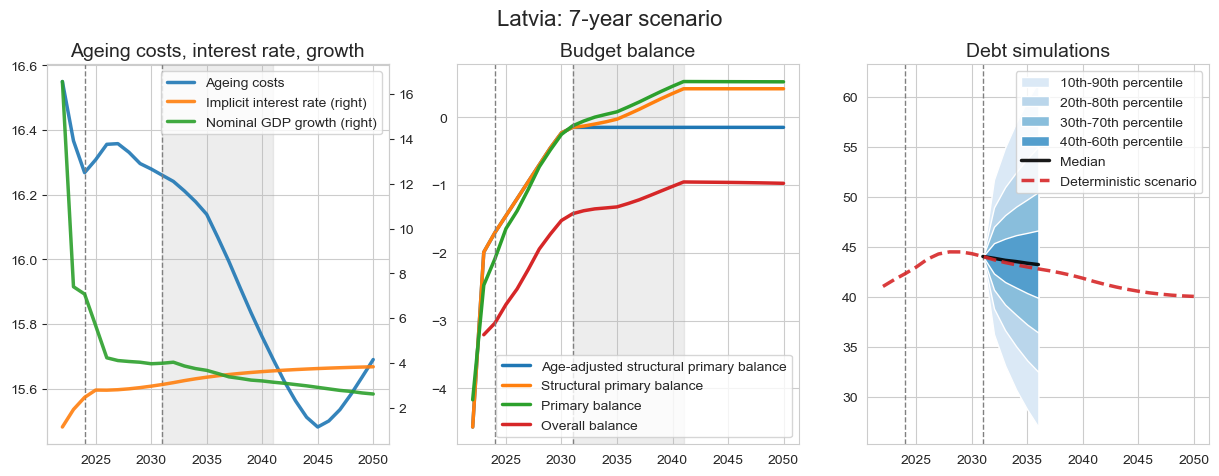

In [82]:
plot_annex_charts(
    country_code_dict, 
    results_dict, 
    output_path, 
    today
    )